In [1]:
import numpy as np
import scipy as sci
import eddington
import os
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
from bisect import bisect
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams.update({'font.size': 18, 'font.weight':'bold'})
plt.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
brn = r'Measurements/Brine/' # Path to pickles directory

with open(brn+'mu.pickle', "rb") as f:
    chnnls = pickle.load(f)[2] # The channels, i.e. [1,2,3,...,8000?]

with open(brn+'EnergyChannel.pickle', "rb") as f:
    engCali = pickle.load(f)
    
with open(brn+'Efficiency.pickle', "rb") as f:
    reLin = pickle.load(f)
    
with open(brn+'rod.pickle', "rb") as f:
    stAng, stAngData,livest = pickle.load(f) # Data of first part, structured as
                                      # stAng = [Angles], stAngData = [HistForFirstAngle, HistForSecondAngle,...]
with open(brn+'sci.pickle', "rb") as f:
    ndAng, ndAngData,livend = pickle.load(f) # Data of second part, same structure
    
with open(brn+'AlRodMu.pickle', "rb") as f:
    mu1 = pickle.load(f)

In [2]:
def FWHM(x,y,index,frac,direction=0):
    value = y[index]*frac
    i = index
    while y[i]>value and i<len(y):
        i+=1
    rIndex=i
    i = index
    while y[i]>value and i>0:
        i-=1
    lIndex=i
    if direction == 0:
        return [(x[rIndex]-x[lIndex])/np.sqrt(8*np.log(1/frac)),lIndex,rIndex]
    if direction == 1:
        return [2*(x[rIndex]-x[index])/np.sqrt(8*np.log(1/frac)),index,rIndex]
    if direction == -1:
        return [2*(x[index]-x[lIndex])/np.sqrt(8*np.log(1/frac)),lIndex,index]
    
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def linFit(x,y,num):
    linData = eddington.FittingData(dict(x = np.hstack((x[:num],x[-num:])), dx = np.hstack((x[:num],x[-num:]))*0.05,
                                     y = np.hstack((y[:num],y[-num:])), dy = np.hstack((y[:num],y[-num:]))*0.05))
    return eddington.fit(linData, eddington.linear)

def Histogram(x,y,binSize):
    exc = len(y)%binSize
    if exc == 0:
        newY = np.sum(np.reshape(y,(-1,binSize)), axis=1)
        newX = np.sum(np.reshape(x,(-1,binSize)), axis=1)/binSize
    else:
        newY = np.sum(np.reshape(y[exc//2:-exc//2],(-1,binSize)), axis=1)
        newX = np.sum(np.reshape(x[exc//2:-exc//2],(-1,binSize)), axis=1)/binSize
    return newX, newY

def firstDerivative(x,y,lins,num=5):
    return (x[(lins+num)//2:-(lins+num)//2+lins%2],
            moving_average(np.array([linFit(x[i+1:i+1+lins],y[i+1:i+1+lins],2).a[1] for i in range(len(y)-lins+1)]),num))

def FitGaussWithBKG(x,y,BKG,index,frac,direction=0):
    sApprox = FWHM(x,y-BKG,index,frac,direction) # [sigma, rIndex, lIndex]
    if direction==0:
        muIdx = (sApprox[1]+sApprox[2])//2
    else:
        muIdx = index
    n=(y-BKG)[muIdx]*(sApprox[0]*np.sqrt(2*np.pi))
    ytag = (y-BKG)[sApprox[1]:sApprox[2]]
    gssData = eddington.FittingData(dict(x=x[sApprox[1]:sApprox[2]], dx=np.full((sApprox[2]-sApprox[1],),1/np.sqrt(12)),
                                     y=ytag, dy=np.sqrt(ytag)))
    gssRe = eddington.fit(gssData, Gaussian, a0=[n,sApprox[0],x[muIdx]])
    return gssRe

def PeaksWithScale(x,y,scale,mult,continu):
    i = 0
    areas = []
    cont=0
    while i<len(x):
        if x[0]+2*scale<x[i] and x[i]+2*scale<x[-1]:
            Rstart = bisect(x,x[i]+scale)
            Rend = bisect(x,x[i]+2*scale)
            RscaleAvg = sum(y[Rstart:Rend])/(Rend-Rstart)
            
            Lstart = bisect(x,x[i]-2*scale)
            Lend = bisect(x,x[i]-scale)
            LscaleAvg = sum(y[Lstart:Lend])/(Lend-Lstart)
            test = y[i]/LscaleAvg + y[i]/RscaleAvg
            if test>mult*2 and cont==0:
                cont=continu
                areas.append(i)
            
            if test<mult*2 and cont>1:
                cont-=1
            
            elif test<mult*2 and cont==1:
                cont=0
                areas.append(i-cont+1)
                
        elif cont>0 and x[i]+2*scale>x[-1]:
            areas.append(i)
            cont=0
        i+=1
    return areas

def xover(ts, cut):
    x = ts > cut
    return x.argmax() if x.any() else -1

In [3]:
@eddington.fitting_function(
    n=3,
    syntax="a[0]**2 * (1+np.cos(x-a[1])**2)/2 *\
            1/(1+a[2]*(1-np.cos(x-a[1])))**2 *\
            (1+a[2]**2*(1-np.cos(x-a[1]))**2)/\
            ((1+np.cos(x-a[1])**2)*(1+a[2]*(1-np.cos(x-a[1]))))")
def NishinaCrossSection(a,x):
    return  a[0]**2 * (1+np.cos(x-a[1])**2)/2 *\
            1/(1+a[2]*(1-np.cos(x-a[1])))**2 *\
            (1+a[2]**2*(1-np.cos(x-a[1]))**2)/\
            ((1+np.cos(x-a[1])**2)*(1+a[2]*(1-np.cos(x-a[1]))))

@eddington.fitting_function(
    n=2,
    syntax="a[0]**2 * (1+np.cos(x-a[1])**2)/2")
def ThomsonCrossSection(a,x):
    return a[0]**2 * (1+np.cos(x-a[1])**2)/2

@eddington.fitting_function(
    n=6,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*np.exp(a[4]*x) + a[5]")
def GaussExp(a,x):
    return a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*np.exp(a[4]*x) + a[5]

@eddington.fitting_function(
    n=4,
    syntax="a[0] + a[1]*(1-np.cos(a[2]*(x-a[3])))")
def comptonEnergyAngle(a,x):
    return a[0] + a[1]*(1-np.cos(a[2]*(x-a[3])))

@eddington.fitting_function(
    n=3,
    syntax="a[0] + a[1]*(1-np.cos(x-a[2]))")
def comptonEnergyAnglewith3param(a,x):
    return a[0] + a[1]*(1-np.cos(x-a[2]))

@eddington.fitting_function(
    n=8,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*x + a[7]")
def twoGaussLin(a,x):
    return  a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) + a[6]*x + a[7]

@eddington.fitting_function(
    n=5,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*x + a[4]")
def Gauss(a,x):
    return a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) + a[3]*x + a[4]


@eddington.fitting_function(
    n=3,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2))")
def Gaussian(a,x):
    return a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2))

@eddington.fitting_function(
    n=14,
    syntax="a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) +\
            a[6]/(a[7]*np.sqrt(2*np.pi))*np.exp(-(x-a[8])**2/(2*a[7]**2)) +\
            a[9]/(a[10]*np.sqrt(2*np.pi))*np.exp(-(x-a[11])**2/(2*a[10]**2)) + a[12]*x + a[13]")
def fourGauss(a,x):
    return  a[0]/(a[1]*np.sqrt(2*np.pi))*np.exp(-(x-a[2])**2/(2*a[1]**2)) +\
            a[3]/(a[4]*np.sqrt(2*np.pi))*np.exp(-(x-a[5])**2/(2*a[4]**2)) +\
            a[6]/(a[7]*np.sqrt(2*np.pi))*np.exp(-(x-a[8])**2/(2*a[7]**2)) +\
            a[9]/(a[10]*np.sqrt(2*np.pi))*np.exp(-(x-a[11])**2/(2*a[10]**2)) + a[12]*x + a[13]

59312.641515047515


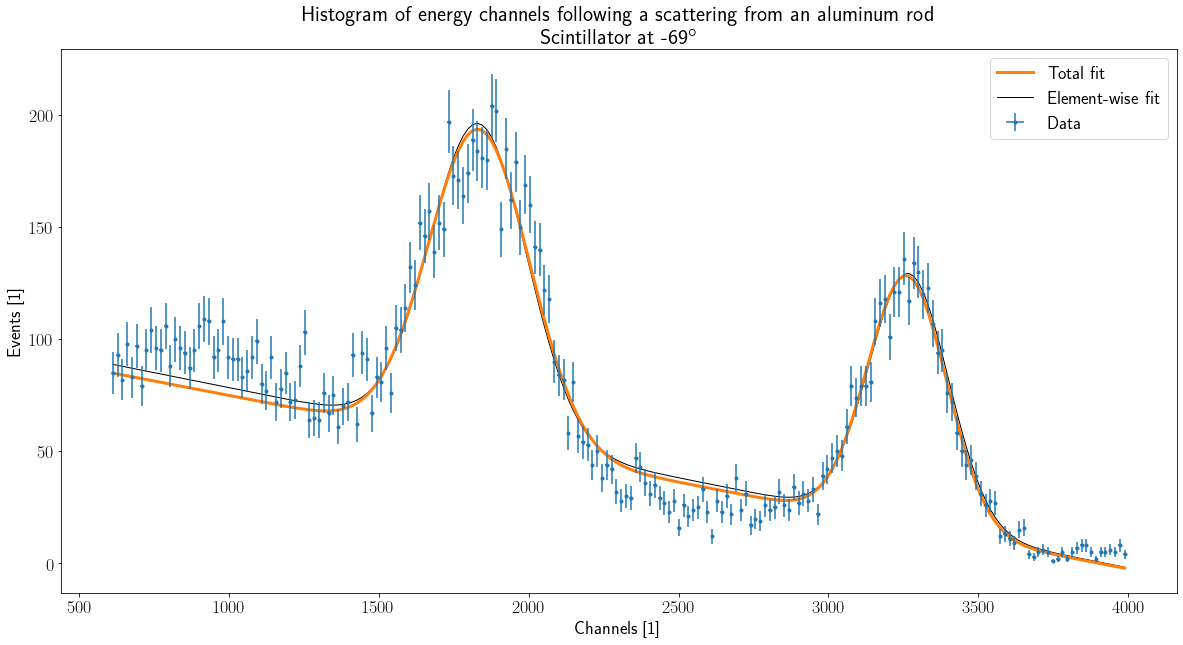

60832.58167334938


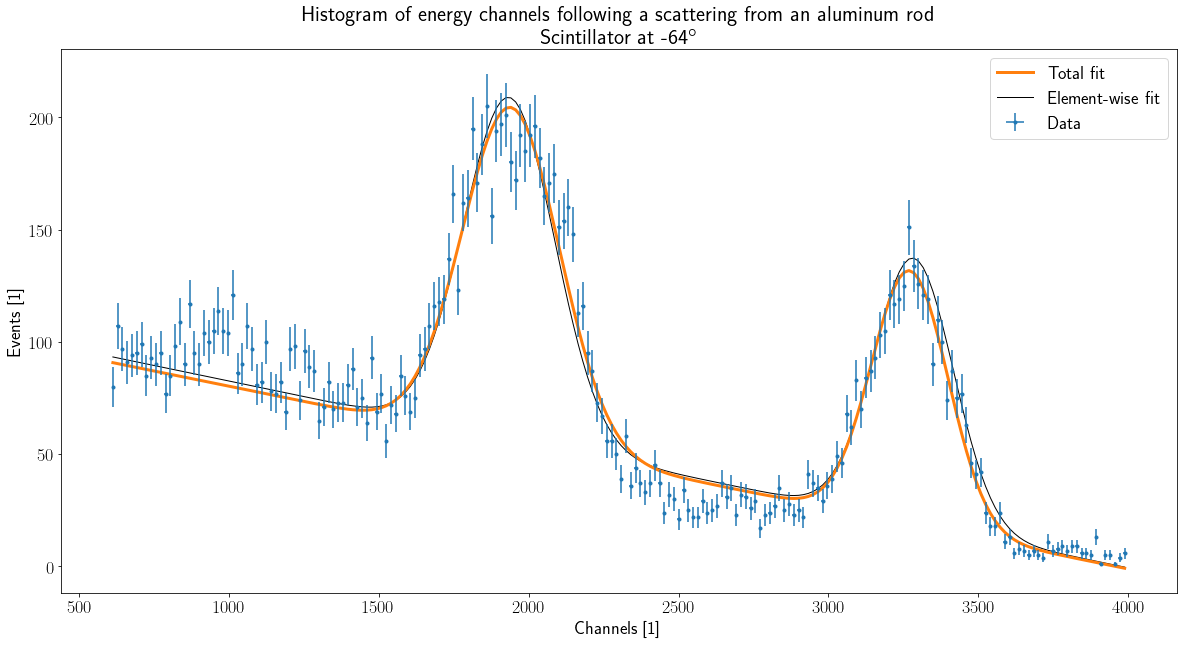

64673.03840235511


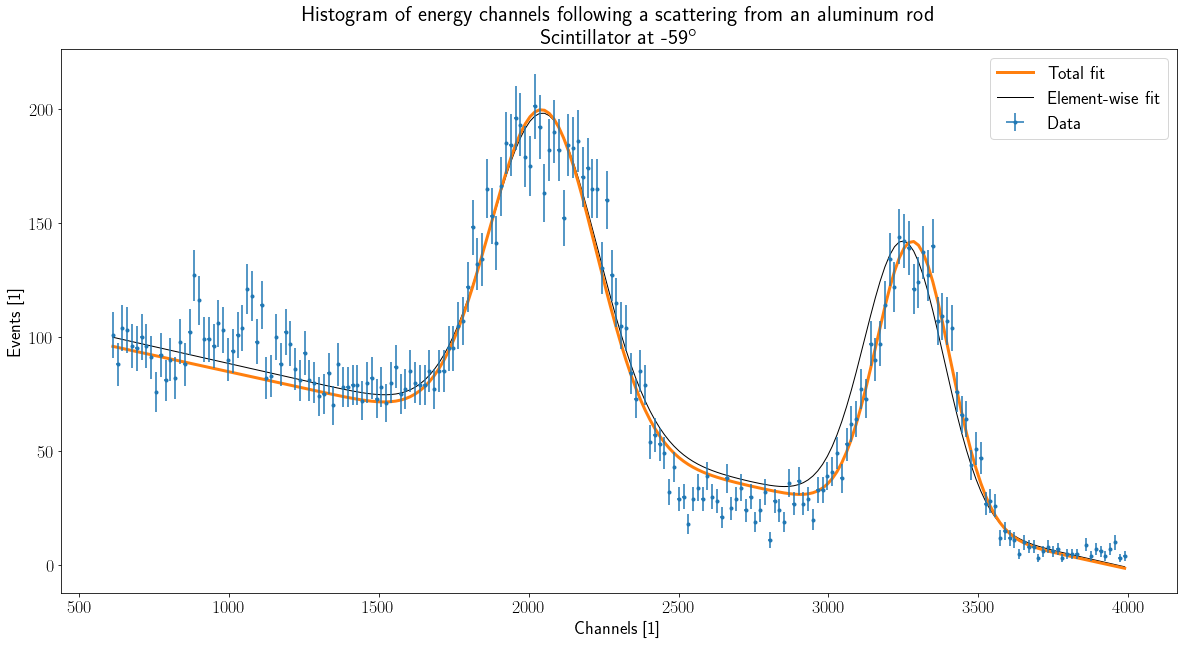

65262.64440391446


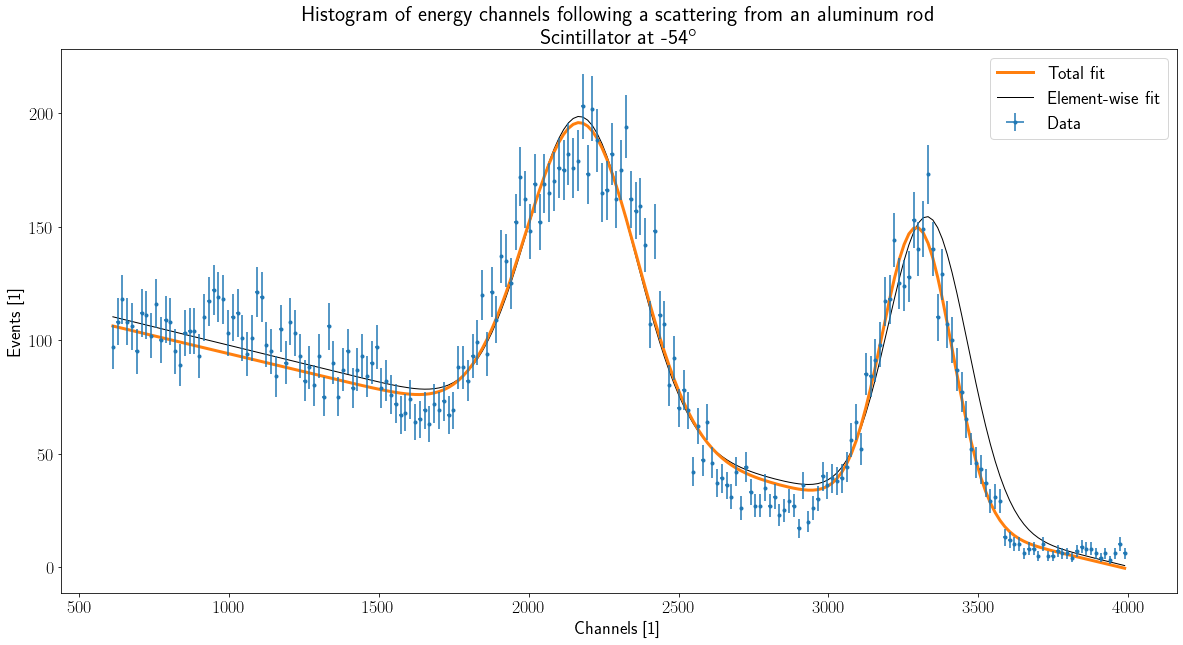

71953.74929993022


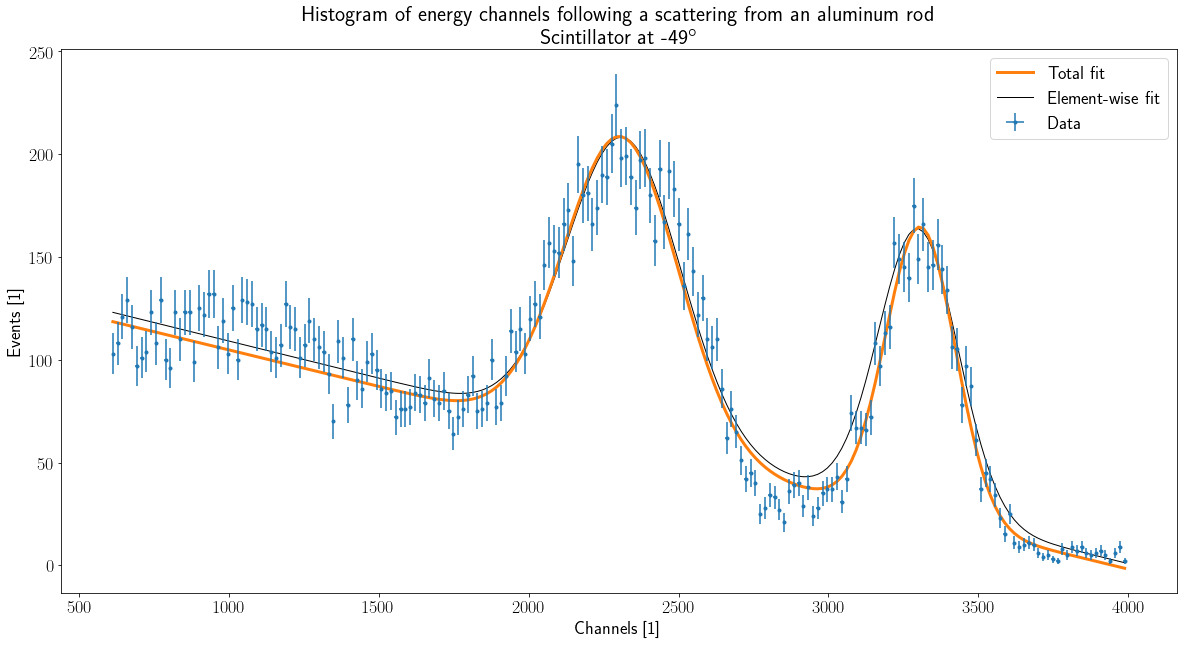

78637.14971606023


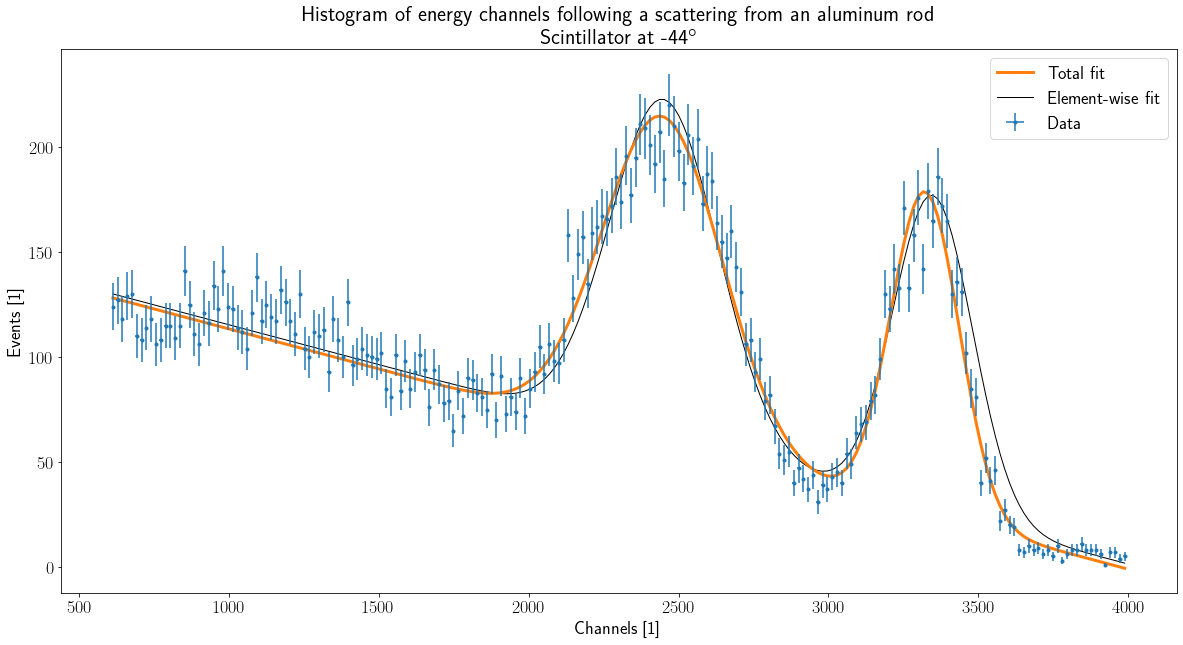

88944.30392430027


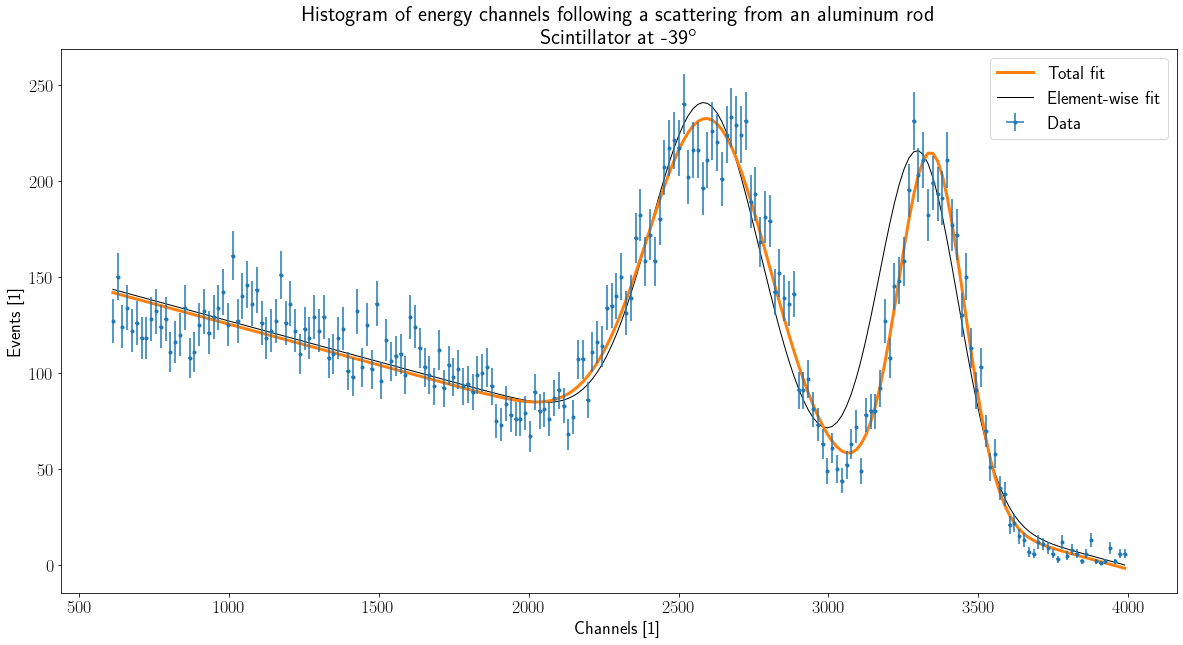

106906.02541273042


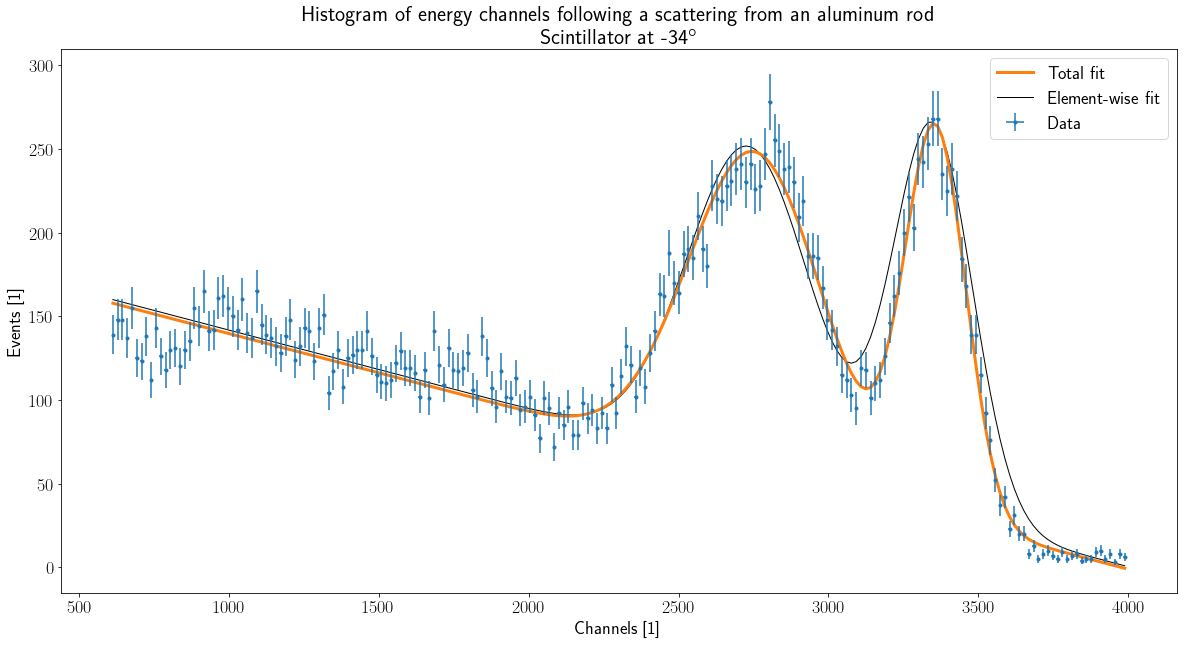

131211.1738720496


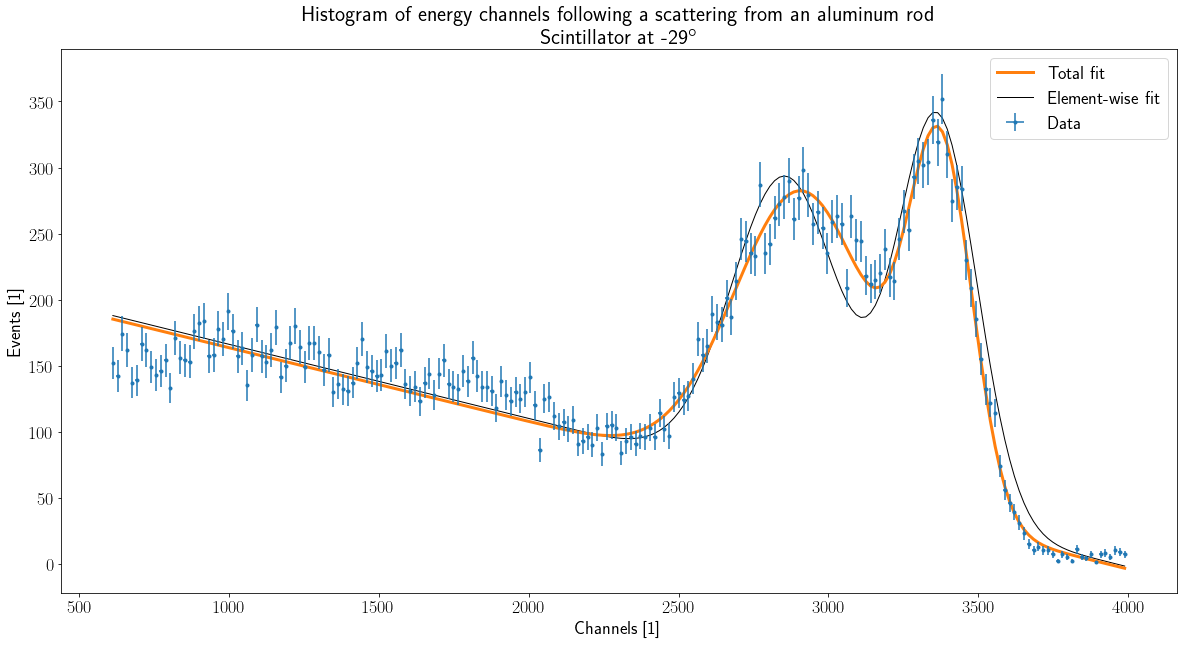

146883.7546600233


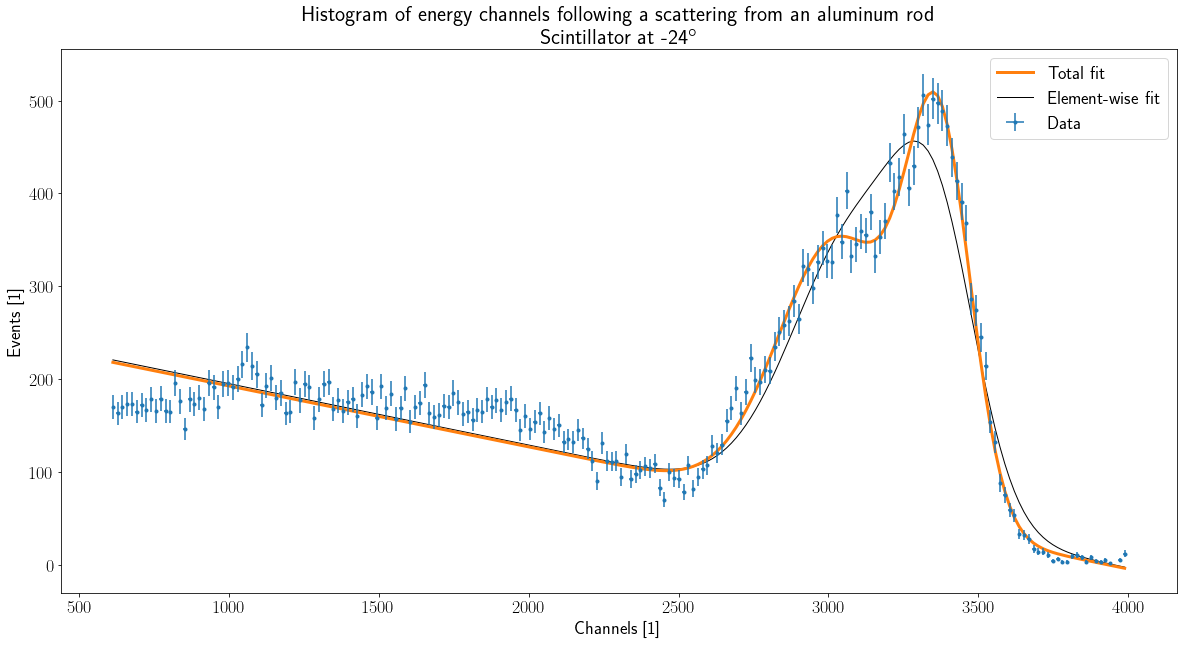

152146.41300558925


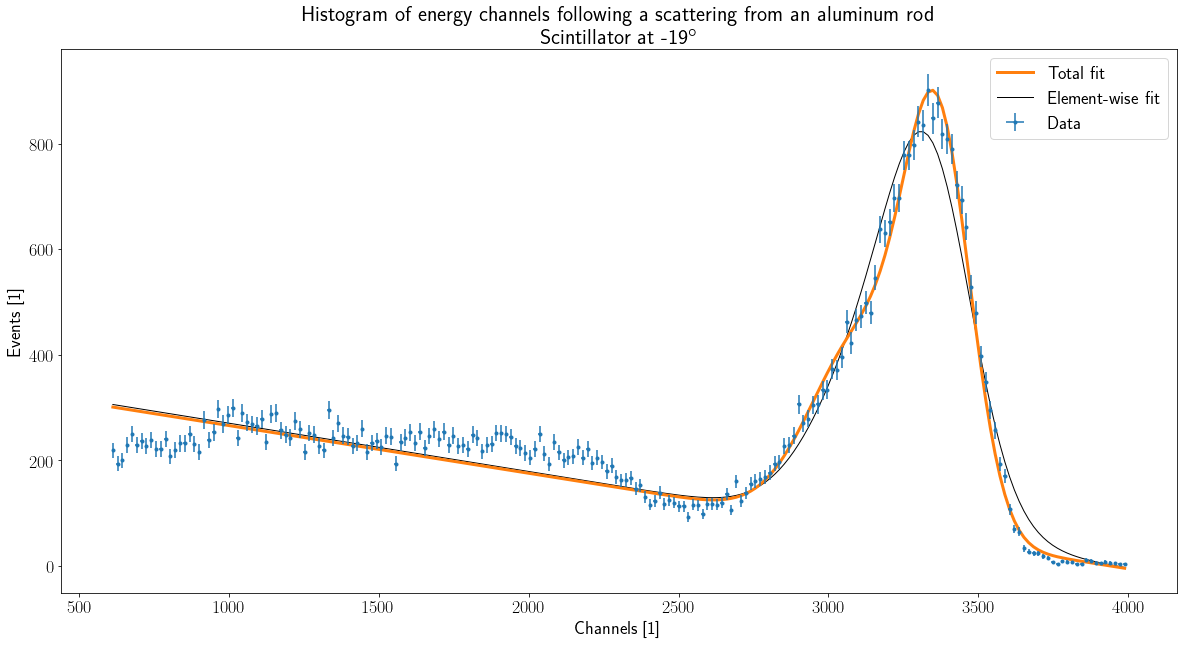

138834.61167073232


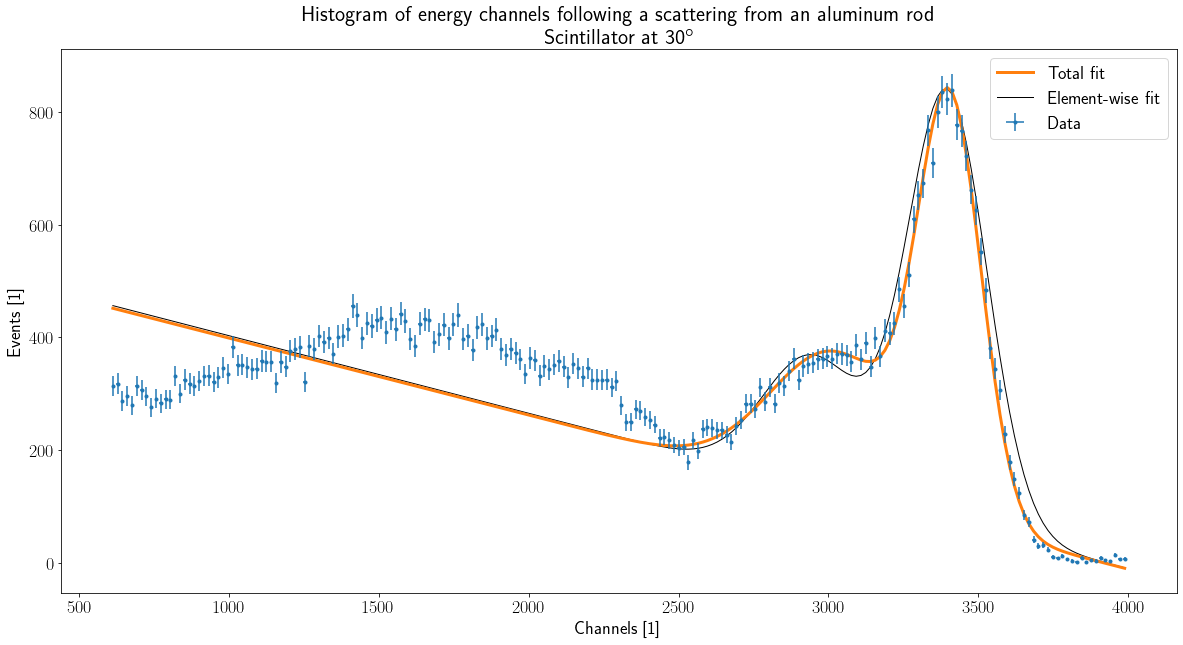

139090.8165384634


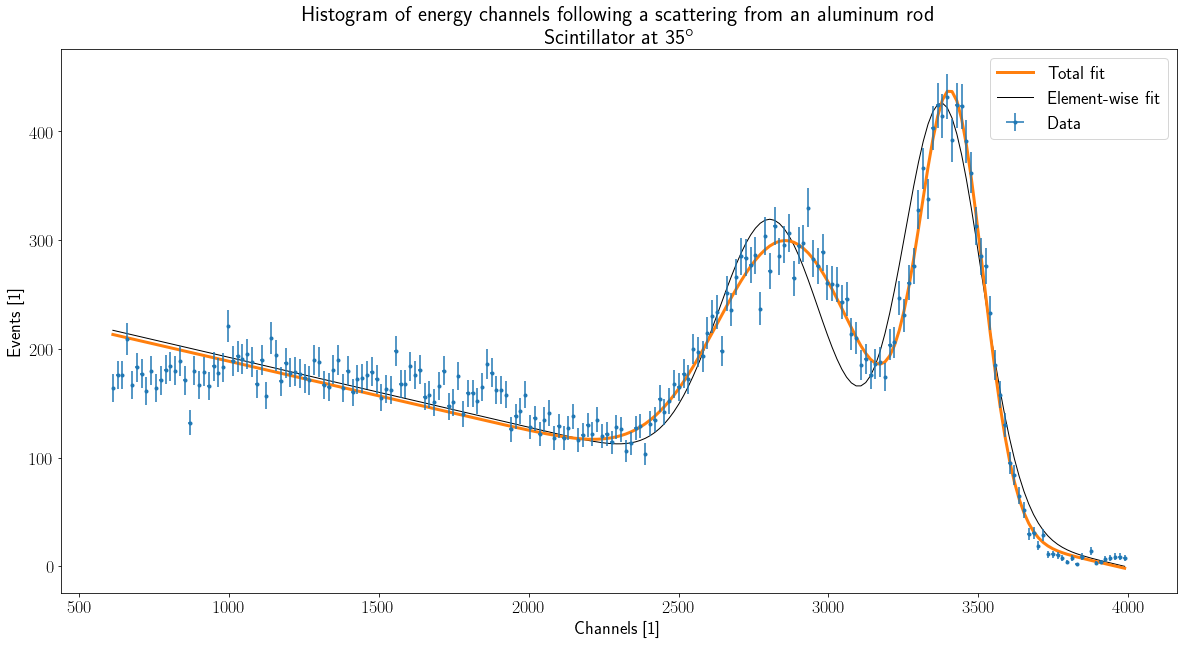

112444.59277864742


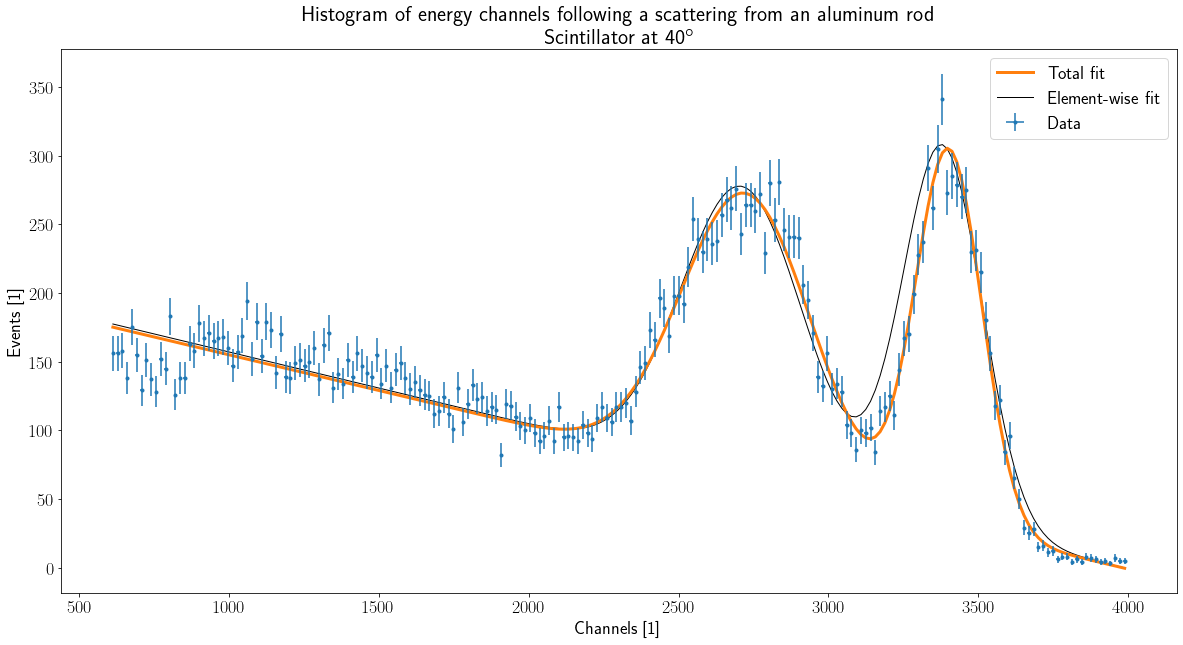

101581.54181350084


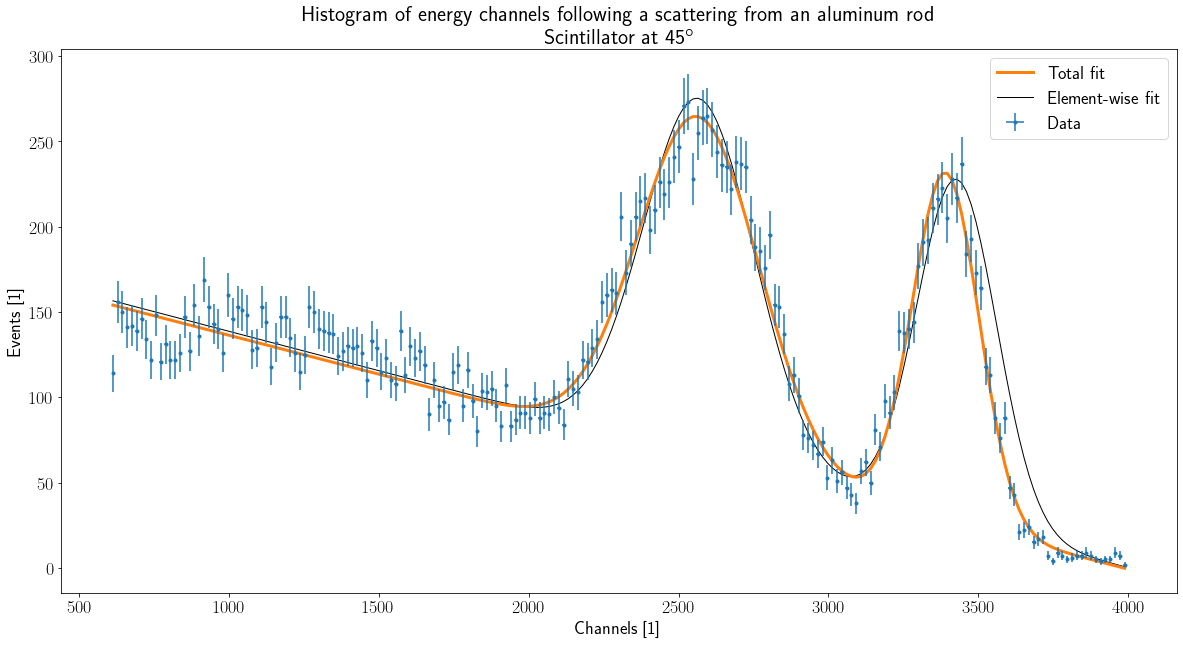

96202.71188395507


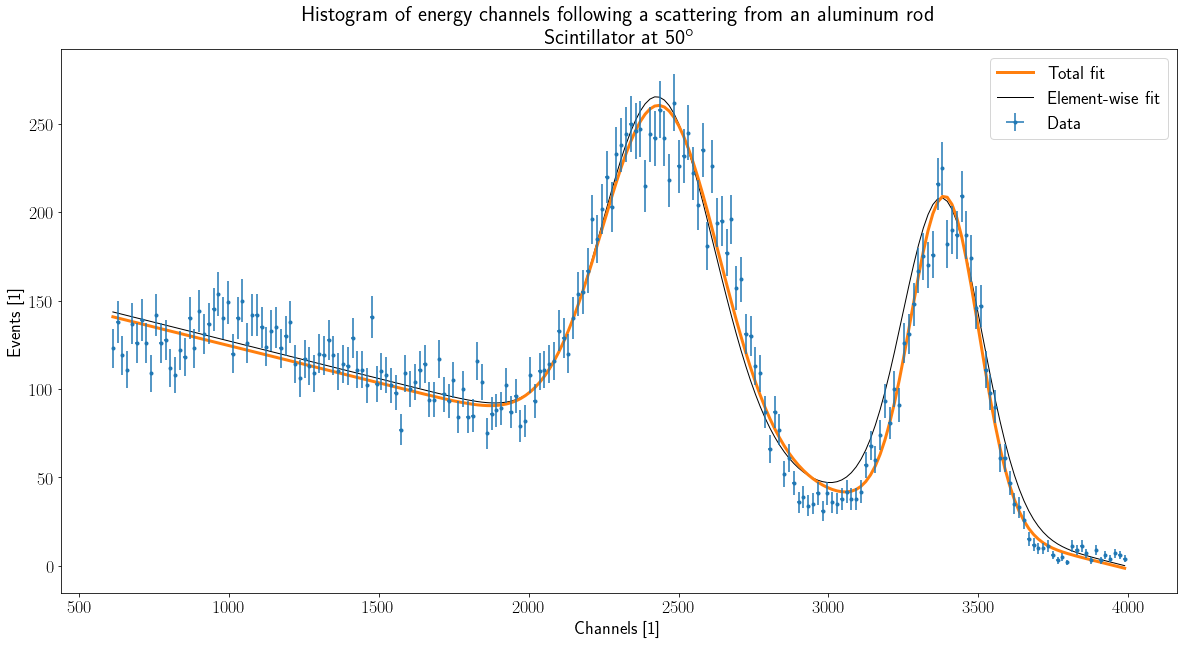

86881.4215604258


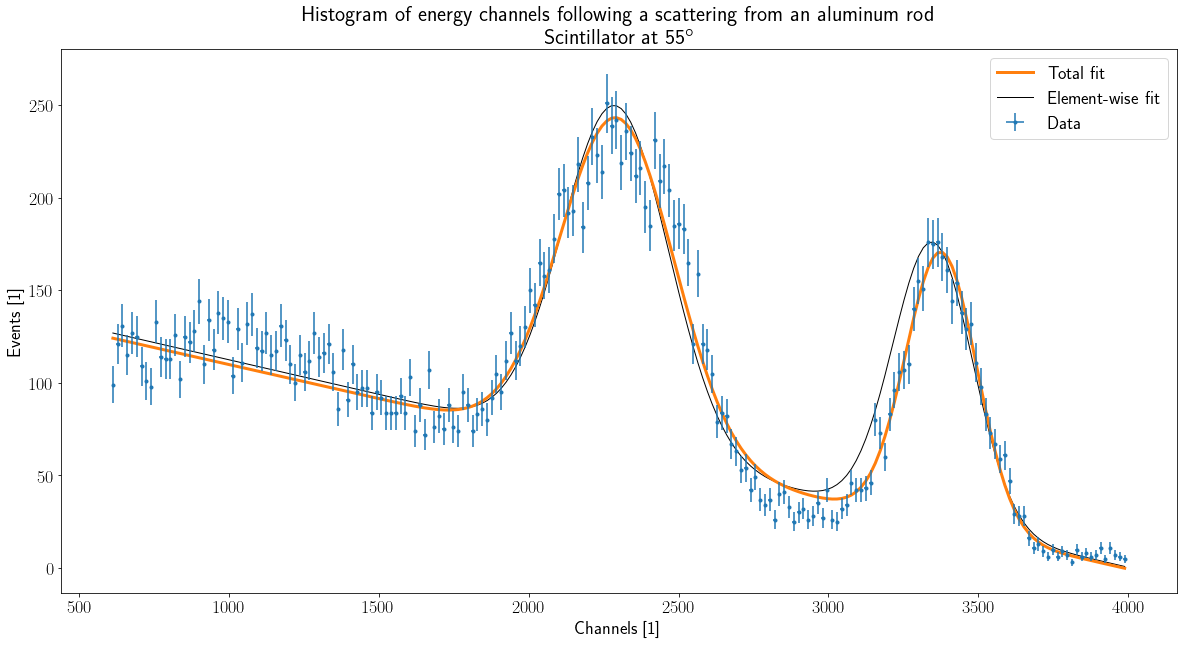

79885.32059357839


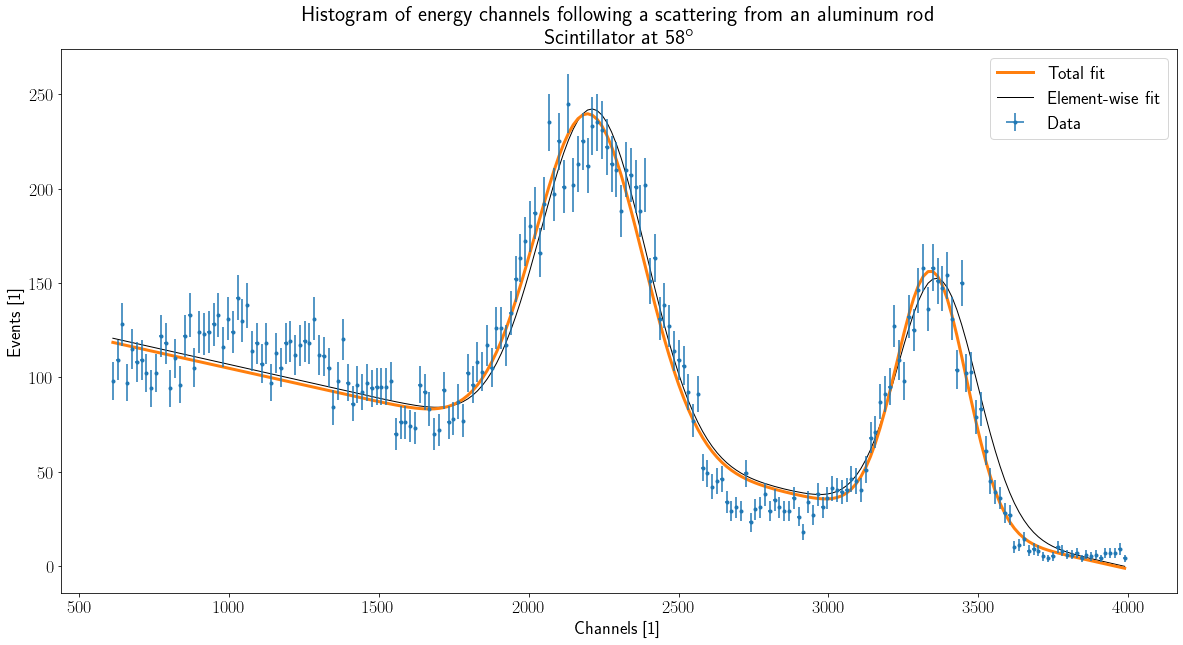

80100.98302204654


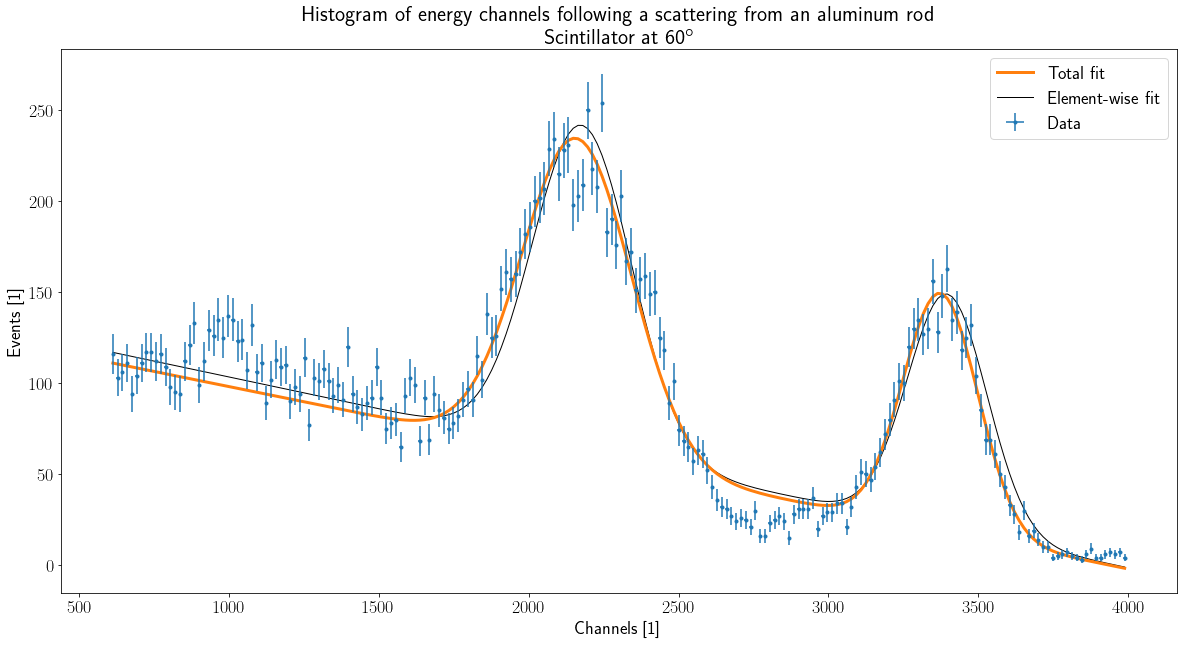

75737.559154063


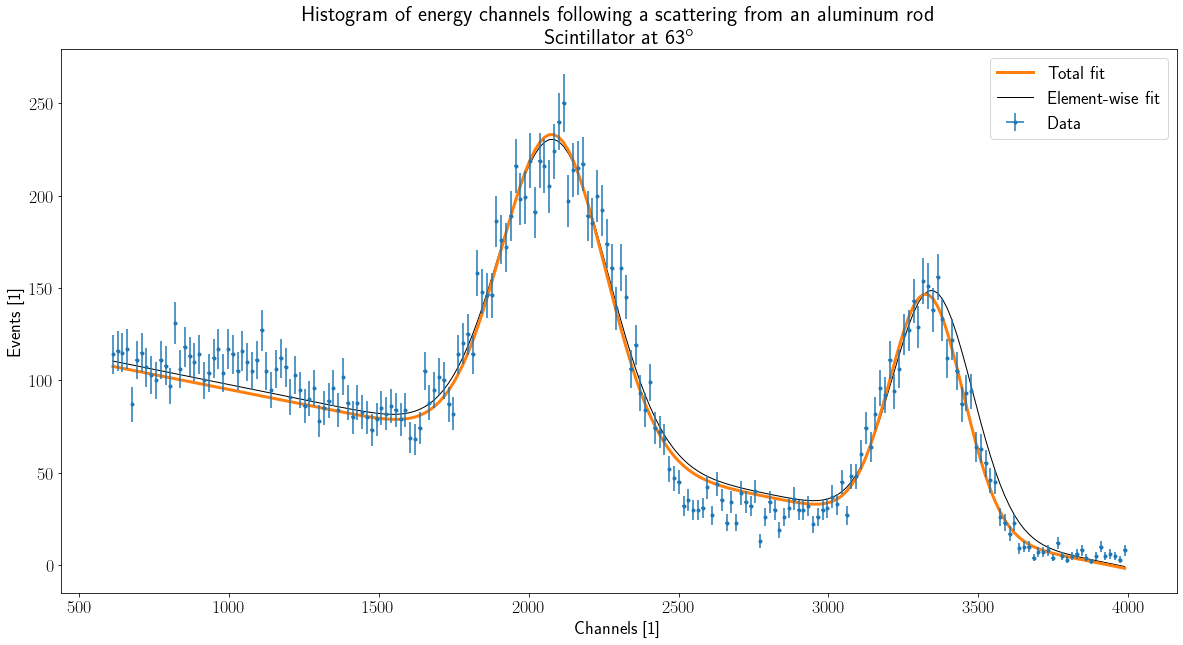

78157.47867430485


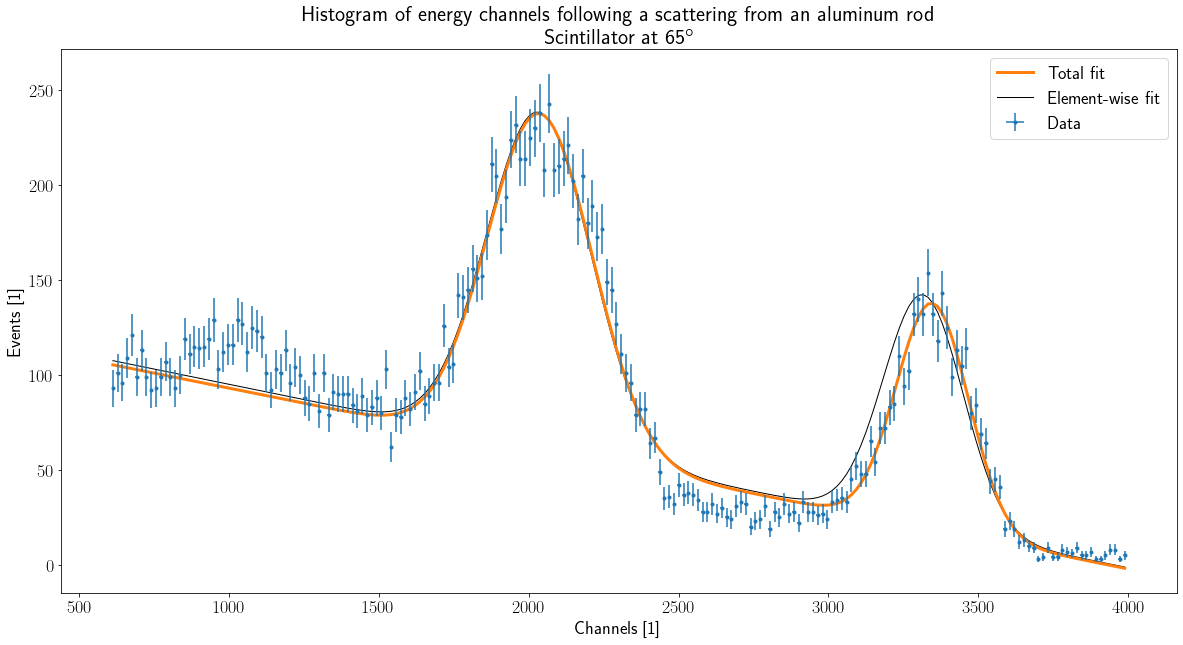

72993.6847275138


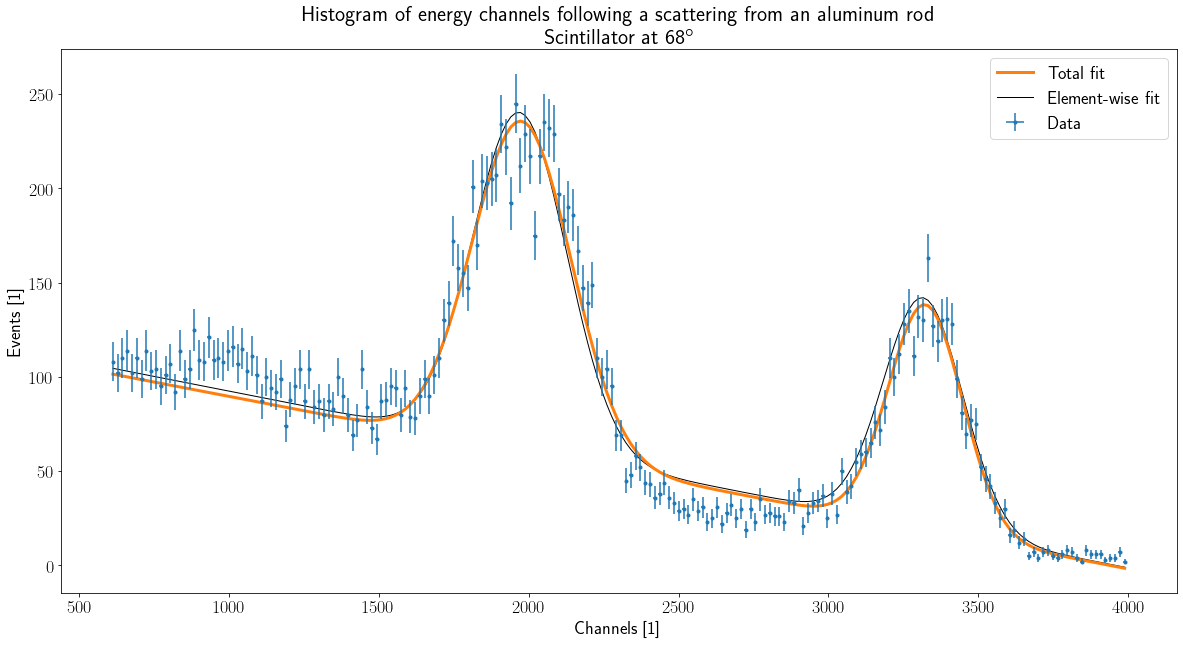

73977.72217987824


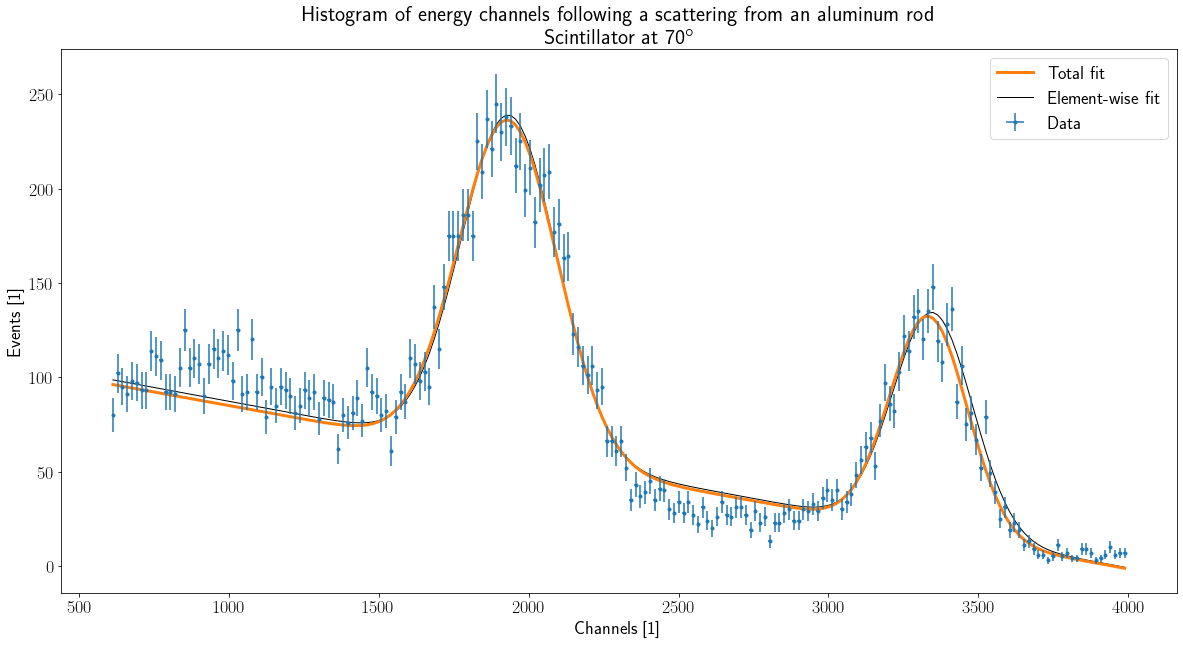

74458.62751119604


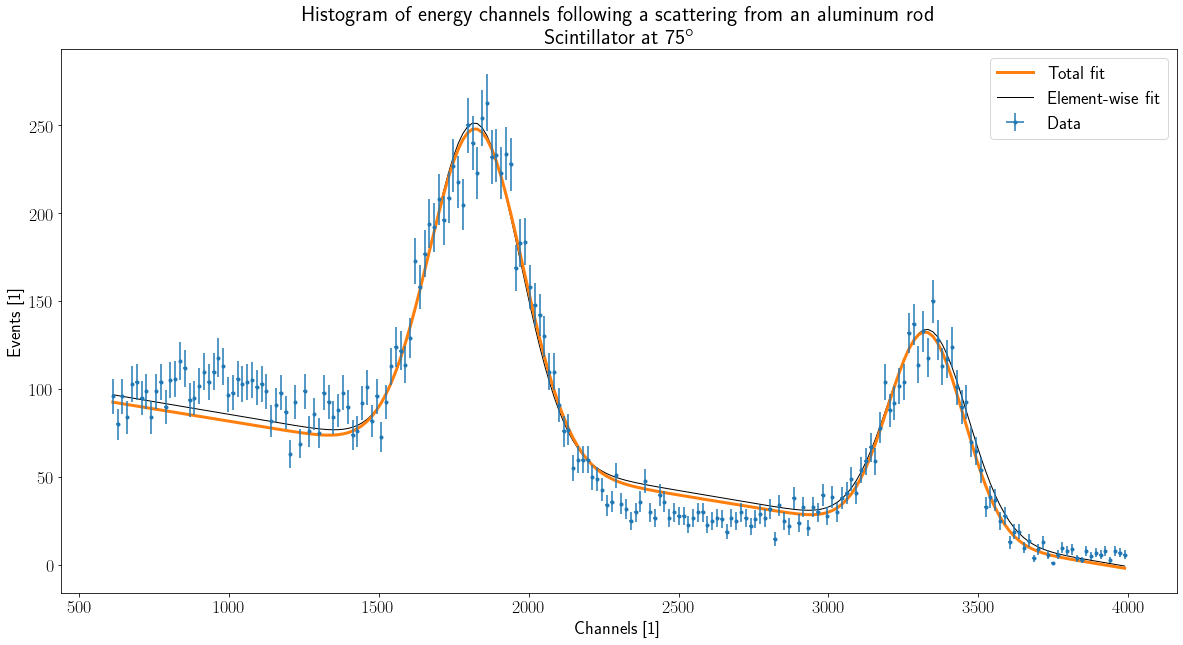

74305.19461569175


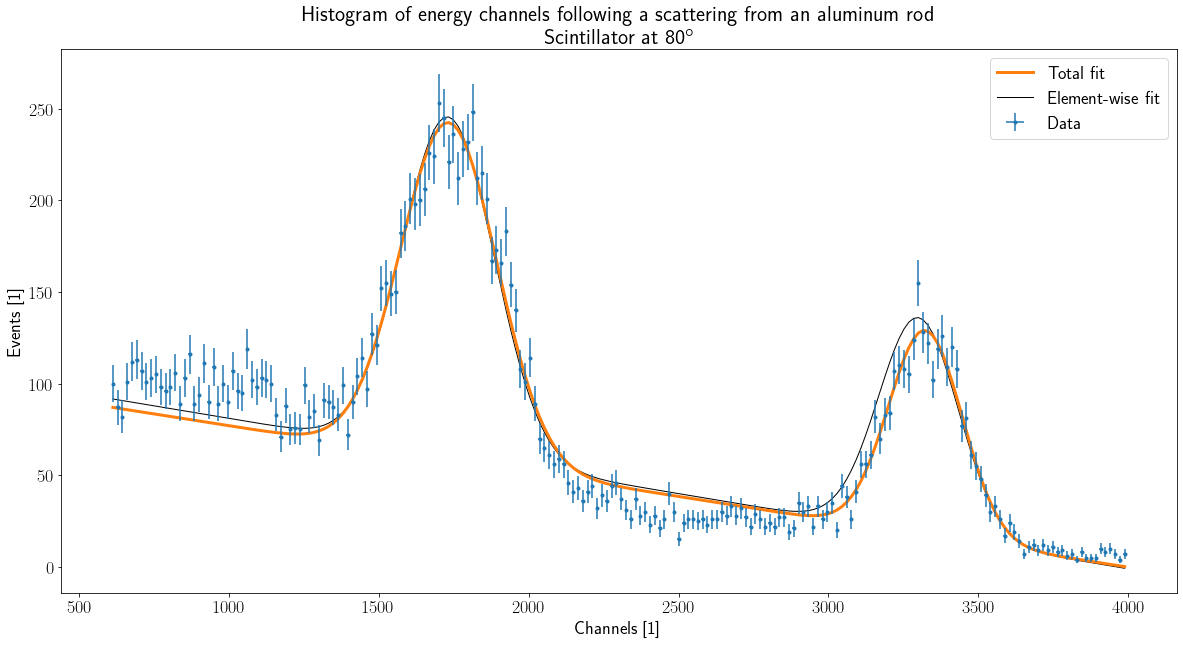

In [6]:
# Try to first make it as smooth as possible and accurate -> Fitting
frac = 2/3
mu1 = []
hist = 16
rng = [600,4000]

channelToIdx = lambda channel: np.array(np.rint((channel-rng[0])//hist), dtype=int)
limiToBKG = lambda lmt, length: np.reshape(np.hstack(([0],np.hstack((np.array(lmt),[length-1])))), (-1,2))
limits = [
    [1500, 2200, 2950, 3600], # -69 -1
    [1550, 2300, 2900, 3650], # -64 0
    [1700,2500, 2900,3700], # -59 1
    [1700,2800, 2900,3700], # -54 2
    [1800,2900, 2900,3750], # -49 3
    [1900,3000, 3000,3750], # -44 4
    [2000,3000, 3000,3750], # -39 5
    [2250,3100, 3100,3750], # -34 6
    [2400,3250, 3250,3700], # -29 7
    [2500,3750], # -24 8
    [2500,3750], # -19 9
    [2650,3750], # -14 10
    [2750,3750], # 20 11
    [2750,3750], # 25 12
    [2500,3250, 3250,3750], # 30 13
    [2400,3200, 3200,3750], # 35 14
    [2200,3100, 3100,3750], # 40 15
    [2000,3100, 3100,3750], # 45 16 
    [2000,2900, 3100,3750], # 50 17
    [1750,2750, 3000,3750], # 55 18
    [1700,2600, 3000,3750], # 58 19
    [1700,2750, 3000,3750], # 60 20
    [1600,2550, 3000,3750], # 63 21
    [1500,2500, 3000,3750], # 65 22
    [1500,2500, 2900,3750], # 68 23
    [1450,2400, 3000,3750], # 70 24
    [1400,2400, 2900,3750], # 75 25
    [1350,2300, 2900,3750]  # 80 26
]
lmtId = [channelToIdx(np.array(lmt)) for lmt in limits]

x, y = Histogram(chnnls[rng[0]:rng[1]],stAngData[0][rng[0]:rng[1]], hist)
x = x[y>0]
y = y[y>0]
xtag = moving_average(x,3)
ytag = moving_average(y,3)

scls = channelToIdx(np.array([1500, 2200, 2950, 3600]))
antiScls = limiToBKG(scls,len(xtag))
BKG = []

for j in range(len(antiScls)):
    if len(BKG)==0:
        BKG = np.array([xtag[antiScls[j,0]:antiScls[j,1]],ytag[antiScls[j,0]:antiScls[j,1]]])
    else:
        BKG = np.hstack((BKG,np.array([xtag[antiScls[j,0]:antiScls[j,1]],ytag[antiScls[j,0]:antiScls[j,1]]])))

BKGdata = eddington.FittingData(dict(x=BKG[0], dx=np.full_like(BKG[0],0.05), y=BKG[1], dy=np.sqrt(BKG[1])))
BKGfit = eddington.fit(BKGdata, eddington.linear)
scls = np.reshape(scls, (-1,2))
gssFits = []
total = eddington.linear(BKGfit.a,xtag)

for j in range(len(scls)):
    cnls = xtag[scls[j,0]:scls[j,1]]
    signal = ytag[scls[j,0]:scls[j,1]] - eddington.linear(BKGfit.a,cnls)
    gaussianData = eddington.FittingData(dict(x=cnls, dx=np.full_like(cnls,hist/np.sqrt(12)), y=signal, dy=np.sqrt(signal)+0.05))
    s = FWHM(cnls,signal,np.argmax(signal),0.5,direction=0)
    gssFits.append(eddington.fit(gaussianData, Gaussian, a0=[np.max(signal)*np.sqrt(2*np.pi)*s[0], s[0], cnls[np.argmax(signal)]]))    
    total+=Gaussian(gssFits[-1].a, xtag)
    
data = eddington.FittingData(dict(x=x, dx=np.full_like(x,hist/np.sqrt(12)), y=y, dy=np.sqrt(y)+0.05))
result = eddington.fit(data, twoGaussLin, a0=[gssFits[0].a[0], gssFits[0].a[1], gssFits[0].a[2], 
                                              gssFits[1].a[0], gssFits[1].a[1], gssFits[1].a[2], 
                                              BKGfit.a[0], BKGfit.a[1]])
# plt.title(f'Histogram of energy channels following a scattering from an Aluminium rod\nScintillator at {stAng[0]}'\
#           +r'$^{\boldsymbol{\circ}}$')
# plt.errorbar(x, y, xerr=np.full_like(x,hist/np.sqrt(12)), yerr=np.sqrt(y)+0.05, label='Data', fmt='.',zorder=1)
# plt.plot(x, twoGaussLin(result.a, x), label='Total fit',zorder=0)
# plt.plot(xtag, total, label='Element-wise fit',zorder=-1)
# plt.xlabel('Channels [1]')
# plt.ylabel('Events [1]')
# plt.legend()
# plt.show()

tnt = [result.a[3:6],np.max(signal)]

for i in range(len(stAngData)):
    if np.abs(stAng[i]-5) > 20:
        x, y = Histogram(chnnls[rng[0]:rng[1]],stAngData[i][rng[0]:rng[1]], hist)
        x = x[y>0]
        y = y[y>0]
        xtag = moving_average(x,3)
        ytag = moving_average(y,3)
        bkgIdx = limiToBKG(lmtId[i],len(xtag))

        BKG = []
        for j in range(len(bkgIdx)):
            if len(BKG)==0:
                BKG = np.array([xtag[bkgIdx[j,0]:bkgIdx[j,1]],ytag[bkgIdx[j,0]:bkgIdx[j,1]]])
            else:
                BKG = np.hstack((BKG,np.array([xtag[bkgIdx[j,0]:bkgIdx[j,1]],ytag[bkgIdx[j,0]:bkgIdx[j,1]]])))

        BKGdata = eddington.FittingData(dict(x=BKG[0], dx=np.full_like(BKG[0],0.05), y=BKG[1], dy=np.sqrt(BKG[1])))
        BKGfit = eddington.fit(BKGdata, eddington.linear)

        if len(lmtId[i])>2:
            lMax = np.max(ytag[lmtId[i][2]:lmtId[i][3]]-eddington.linear(BKGfit.a,xtag[lmtId[i][2]:lmtId[i][3]]))
            mu = xtag[lmtId[i][2]:lmtId[i][3]][np.argmax(ytag[lmtId[i][2]:lmtId[i][3]]-eddington.linear(BKGfit.a,xtag[lmtId[i][2]:lmtId[i][3]]))]
        else:
            lMax = np.max(ytag[lmtId[i][0]:lmtId[i][1]]-eddington.linear(BKGfit.a,xtag[lmtId[i][0]:lmtId[i][1]]))//2
            mu = xtag[lmtId[i][0]:lmtId[i][1]][np.argmax(ytag[lmtId[i][0]:lmtId[i][1]]-eddington.linear(BKGfit.a,xtag[lmtId[i][0]:lmtId[i][1]]))]
        single = (ytag - Gauss([lMax/tnt[1]*tnt[0][0], tnt[0][1], mu, BKGfit.a[1], BKGfit.a[0]],xtag))[lmtId[i][0]:lmtId[i][1]]
        xs = xtag[lmtId[i][0]:lmtId[i][1]][single>0]
        single = single[single>0]
        data = eddington.FittingData(dict(x=xs, dx=np.full_like(xs, hist/np.sqrt(12)), y=single, dy=np.sqrt(single) ))
        s = FWHM(xs,single,np.argmax(single),0.5,direction=0)
        result = eddington.fit(data, Gaussian, a0=[np.max(single)*np.sqrt(2*np.pi)*s[0], s[0], xs[np.argmax(single)]])
        finData = eddington.FittingData(dict(x=x, dx=np.full_like(x, hist/np.sqrt(12)), y=y, dy=np.sqrt(y)))
        finRe = eddington.fit(finData, twoGaussLin, a0=[result.a[0], result.a[1], result.a[2], 
                                    lMax/tnt[1]*tnt[0][0], tnt[0][1], mu,
                                    BKGfit.a[1], BKGfit.a[0]])
        
        mu1.append([finRe.a[2],finRe.a[1]/np.sqrt(finRe.a[0]),stAng[i],1/np.sqrt(12),\
                    finRe.a[0]/hist,finRe.aerr[0]/hist,livest[i]])
#         print(finRe.a[0])
        
        plt.title(f'Histogram of energy channels following a scattering from an aluminum rod\nScintillator at {stAng[i]}'\
                  +r'$^{\boldsymbol{\circ}}$')
        plt.errorbar(x, y, xerr=np.full_like(x,hist/np.sqrt(12)), yerr=np.sqrt(y), label='Data', fmt='.', zorder=1)
        plt.plot(x, twoGaussLin(finRe.a, x), label='Total fit', linewidth=3, zorder=0)
        plt.plot(x, twoGaussLin(finRe.a0, x), label='Element-wise fit', linewidth=1, zorder=-1,c='k')
        plt.xlabel('Channels [1]')
        plt.ylabel('Events [1]')
        plt.legend()
        plt.savefig(f"Fits/TwoGauss/AluminiumTwoGaussFit-{'P' if stAng[i]>0 else 'N'}{np.abs(stAng[i])}.pdf")
        plt.show()
    
mu1 = np.array(mu1).T
with open(brn+'AlRodMu.pickle', 'wb') as f:
    pickle.dump(mu1, f)

In [8]:
max(livend)

363.011

In [ ]:
## limits = [
#     [[1550,2300], [2900,3650]], # -64
#     [[1700,2500], [2900,3700]], # -59
#     [[1700,2800], [2900,3700]], # -54
#     [[1800,2900], [2900,3750]], # -49
#     [[1900,3000], [3000,3750]], # -44
#     [[2000,3000], [3000,3750]], # -39
#     [[2250,3100], [3100,3750]], # -34
#     [[2400,3250], [3250,3700]], # -29
#     [[2500,3750]], # -24
#     [[2500,3750]], # -19
#     [[2650,3750]], # -14
#     [[2750,3750]], # 20
#     [[2750,3750]], # 25
#     [[2500,3750]], # 30
#     [[2400,3200], [3200,3750]], # 35
#     [[2200,3100], [3100,3750]], # 40
#     [[2000,3100], [3100,3750]], # 45
#     [[2000,2900], [3100,3750]], # 50
#     [[1750,2750], [3000,3750]], # 55
#     [[1700,2600], [3000,3750]], # 58
#     [[1700,2750], [3000,3750]], # 60
#     [[1600,2550], [3000,3750]], # 63
#     [[1500,2500], [3000,3750]], # 65
#     [[1500,2500], [2900,3750]], # 68
#     [[1450,2400], [3000,3750]], # 70
#     [[1400,2400], [2900,3750]], # 75
#     [[1350,2300], [2900,3750]]  # 80
# ]


## OLD
#         BKG = eddington.linear(linFit(x,y,3).a,x)
#         plt.plot(x,BKG)
#         plt.show()
#         sApprox = FWHM(x, y-BKG, np.argmax(y-BKG), frac)
#         edge = [bisect(x,int((x[sApprox[1]]+x[sApprox[2]])/2 - 2*sApprox[0])), 
#                 bisect(x,int((x[sApprox[1]]+x[sApprox[2]])/2 + 4*sApprox[0]))]
#         print(edge)
#         mvd = [x[edge[0]:edge[1]], y[edge[0]:edge[1]]]
#         mvdRe = linFit(mvd[0], mvd[1], 20)
#         BKG = eddington.linear(mvdRe.a, mvd[0])
#         gssRe = FitGaussWithBKG(mvd[0], mvd[1], BKG, np.argmax(mvd[1]), frac)
#         mu1.append([gssRe.a[2],gssRe.a[1]/np.sqrt(gssRe.a[0]),stAng[i],1/np.sqrt(12), gssRe.a[0]/hist, gssRe.aerr[0]/hist,livest[i]])
#         plt.bar(x, y, width=0.8*hist, snap=False)
#         plt.plot(mvd[0], Gaussian(gssRe.a,mvd[0])+BKG, c='k')
#         plt.title(f'Al Rod - Angle = {stAng[i]}')
#         plt.show()
        
#     if np.abs(stAng[i])>190 and np.abs(stAng[i])<36:
#         lins = 12
#         hist = 15
#         rng = [2250,3850]
#         x, y = Histogram(chnnls[rng[0]:rng[1]],stAngData[i][rng[0]:rng[1]], hist)
#         stDer = firstDerivative(x,y,lins)
#         x, y = Histogram(chnnls[rng[0]:rng[1]],stAngData[i][rng[0]:rng[1]], 7)
#         num = 100//7
#         y = moving_average(y, num)
#         x = moving_average(x, num)
#         piks = []
#         for j in range(len(stDer[1])-1):
#             if stDer[1][j]>=0 and stDer[1][j+1]<0 and stDer[0][j]<3450:
#                 piks.append(bisect(x,stDer[0][j]))
            
#         if len(piks)!=2:
#             continue
        
#         BKGre = linFit(x, y, 5)
#         BKG = eddington.linear(BKGre.a,x)
#         gssR = FitGaussWithBKG(x, y, BKG, piks[1], frac, direction = 1)
#         gssL = FitGaussWithBKG(x, y, BKG+Gaussian(gssR.a,x), piks[0], frac)
#         totData = eddington.FittingData(dict(x=x, dx=np.full(x.size,1/np.sqrt(12)),
#                                              y=y, dy=np.sqrt(y)))
#         totRe = eddington.fit(totData, twoGaussLin, a0=[gssL.a[0],gssL.a[1],gssL.a[2],
#                                                         gssR.a[0],gssR.a[1],gssR.a[2],BKGre.a[0],BKGre.a[1]])
#         if totRe.a[2]<totRe.a[5]:
#             mu1.append([totRe.a[2],totRe.a[1]/np.sqrt(totRe.a[0]),stAng[i],1/np.sqrt(12),totRe.a[0]/7,totRe.aerr[0]/7,livest[i]])
#         else:
#             mu1.append([totRe.a[5],totRe.a[4]/np.sqrt(totRe.a[3]),stAng[i],1/np.sqrt(12),totRe.a[3]/7,totRe.aerr[3]/7,livest[i]])
#         plt.plot(x,twoGaussLin(totRe.a,x)/7*3, c='k')
#         piks = np.array([[x[pik],(y)[pik]] for pik in piks]).T
#         plt.scatter(piks[0], piks[1]/7*3, marker='x', c='r', s=100)
#         x, y = Histogram(chnnls[rng[0]:rng[1]],stAngData[i][rng[0]:rng[1]], 3)
#         plt.bar(x, y, width=0.6*3, snap=False)
#         plt.title(f'Al Rod - Angle = {stAng[i]}')
#         plt.show()

Results:

Initial parameters' values:
	0.0016666666666666668 0.0019569471624266144 0.11117747335203879
Fitted parameters' values:
	a[0] = 1.489048e-3 ± 4.240e-6 (0.2847% error)
	a[1] = 1.94292e-3 ± 1.257e-5 (0.6468% error)
	a[2] = 4.7453e-2 ± 1.886e-3 (3.975% error)
Fitted parameters covariance:
[[ 5.572e-12 -1.371e-11 -4.832e-10]
 [-1.371e-11  4.895e-11  1.945e-09]
 [-4.832e-10  1.945e-09  1.103e-06]]
Chi squared: 70.98
Degrees of freedom: 22
Chi squared reduced: 3.226
P-probability: 4.637e-7

2.7188396211927546
514.6899513280193
671.5701811046864


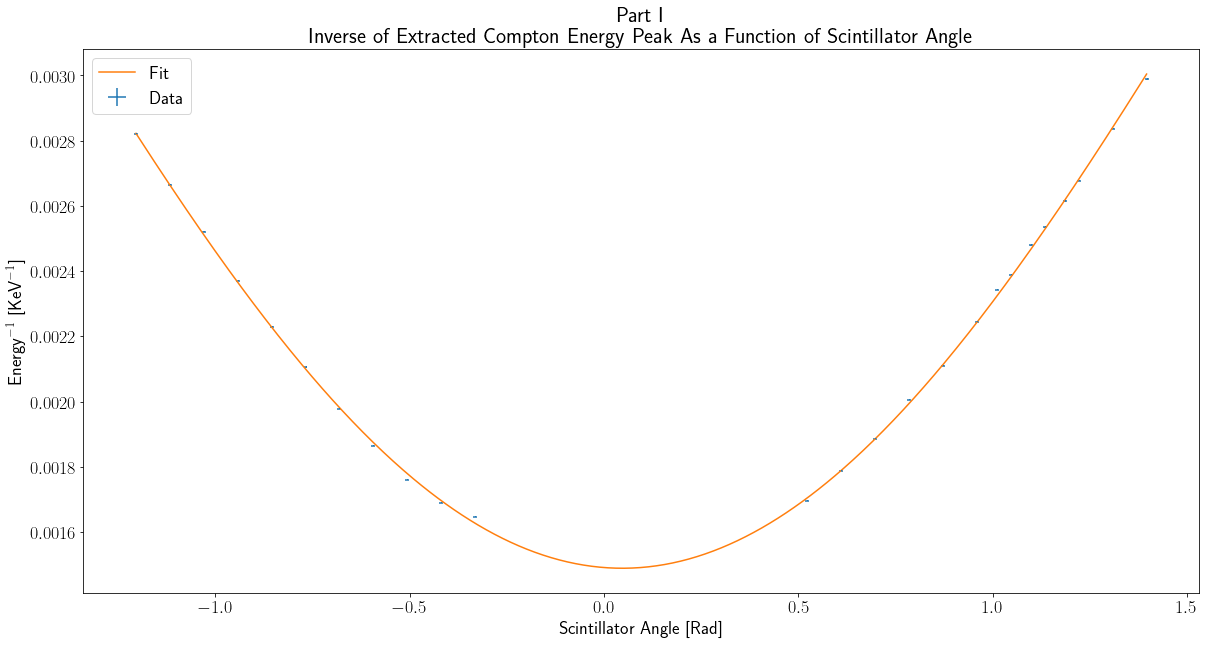

In [4]:
with open(brn+'AlRodMu.pickle', 'rb') as f:
    mu1 = pickle.load(f)
mu1[0] = 1/eddington.linear(engCali.a,mu1[0])
mu1[1] = mu1[1]*engCali.a[1]*mu1[0]**2
mu1[2] = mu1[2]*np.pi/180
mu1[3] = mu1[3]*np.pi/180
fitData = eddington.FittingData(dict(x=mu1[2],dx=mu1[3],y=mu1[0],dy=mu1[1]))
re = eddington.fit(fitData, comptonEnergyAnglewith3param, [1/600, 1/511, 6.37*np.pi/180])
x = np.linspace(min(mu1[2]),max(mu1[2]), num=500)
re.save_txt('Fits/AlRodComptonEnergyFit.txt')
print(re)
print(re.a[2]*180/np.pi)
print(1/re.a[1])
print(1/re.a[0])
plt.errorbar(x=mu1[2],xerr=mu1[3],y=mu1[0],yerr=mu1[1], fmt=',', label='Data')
plt.plot(x, comptonEnergyAnglewith3param(re.a, x), label='Fit')
plt.xlabel(r'Scintillator Angle [Rad]')
plt.ylabel(r'Energy$^{-1}$ [KeV$^{-1}$]')
plt.title('Part I\nInverse of Extracted Compton Energy Peak As a Function of Scintillator Angle')
plt.legend()
plt.savefig('Fits/AlRodComptonEnergyFit.pdf')
plt.savefig('Fits/AlRodComptonEnergyFit.png')
plt.show()

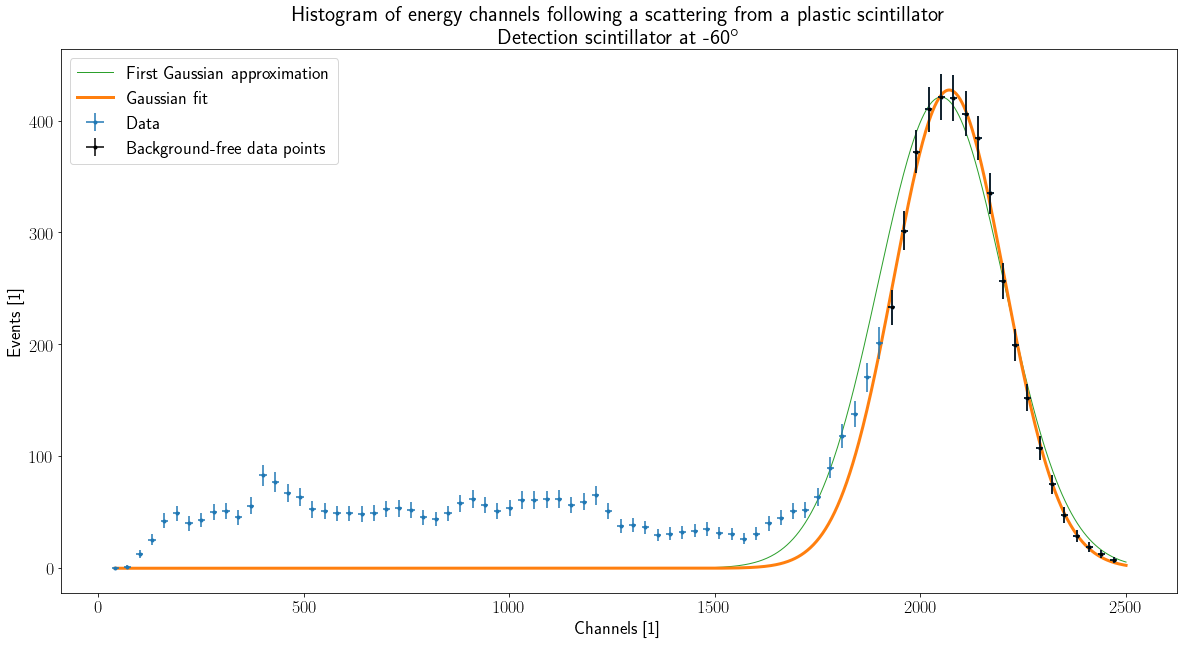

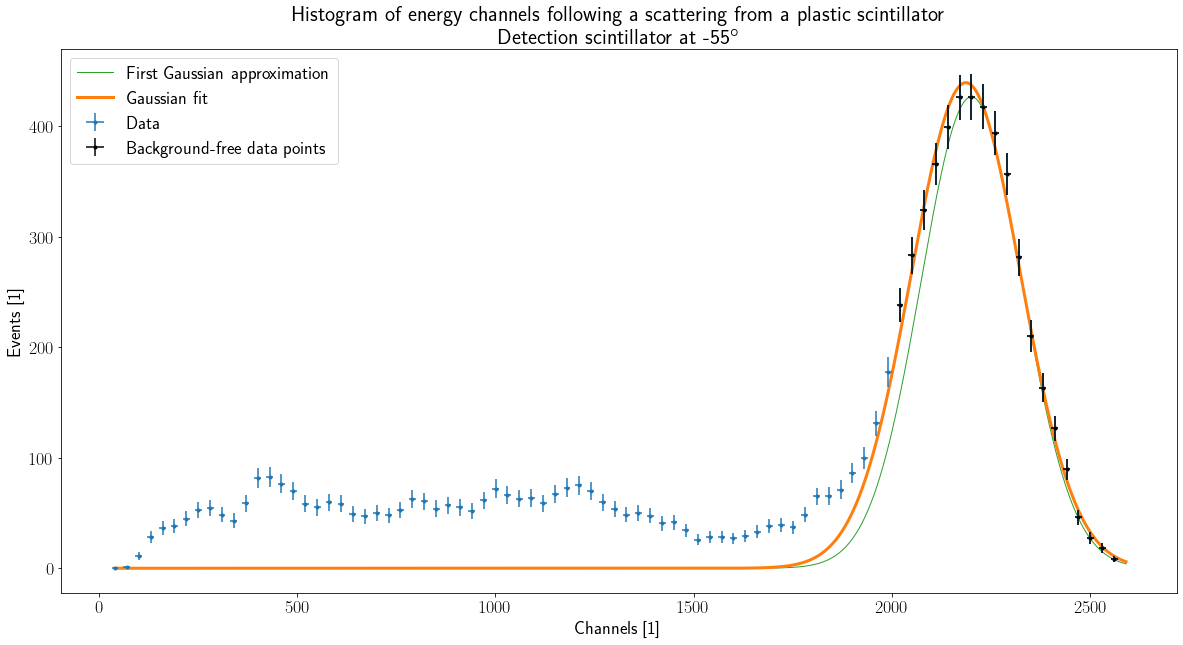

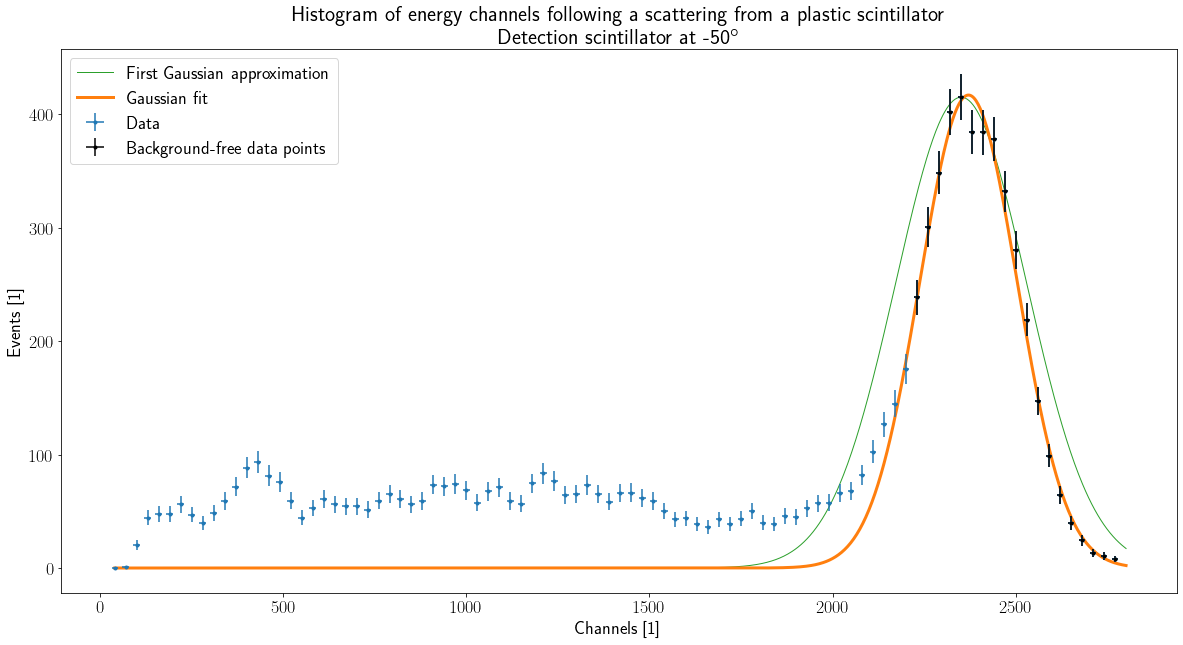

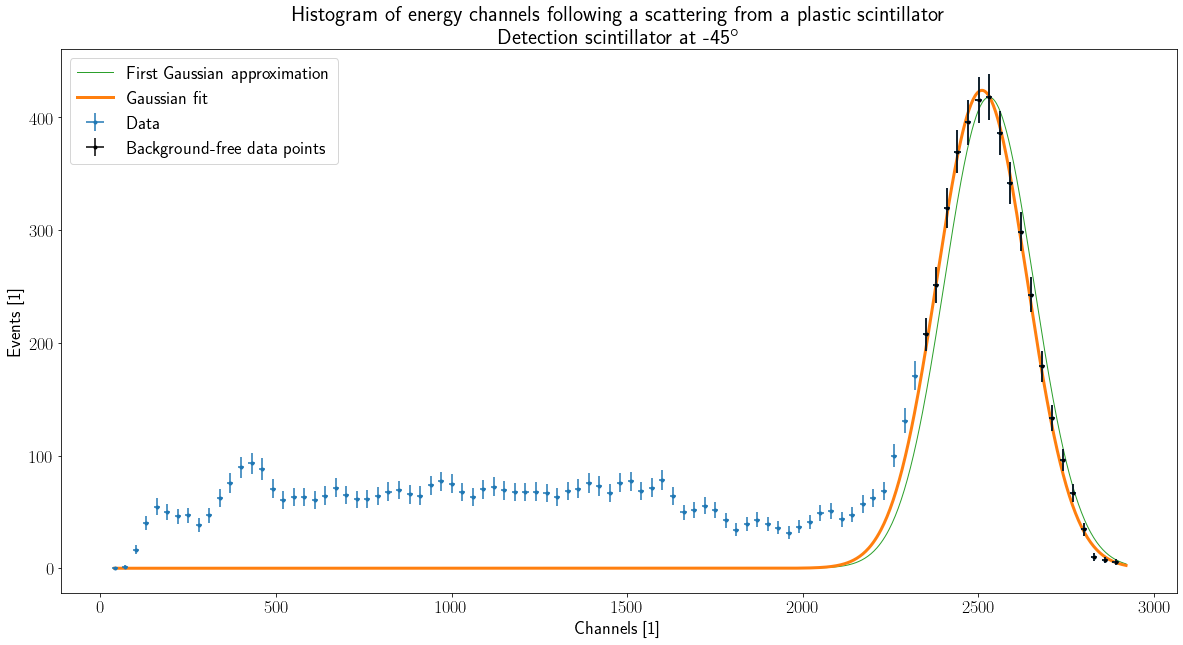

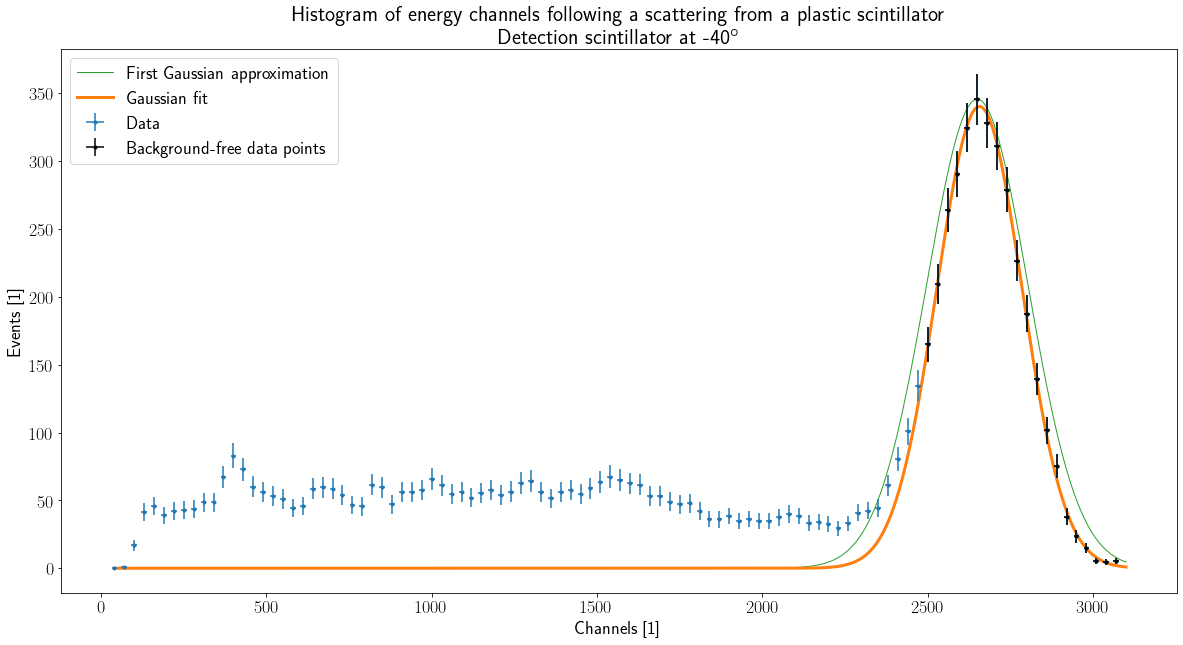

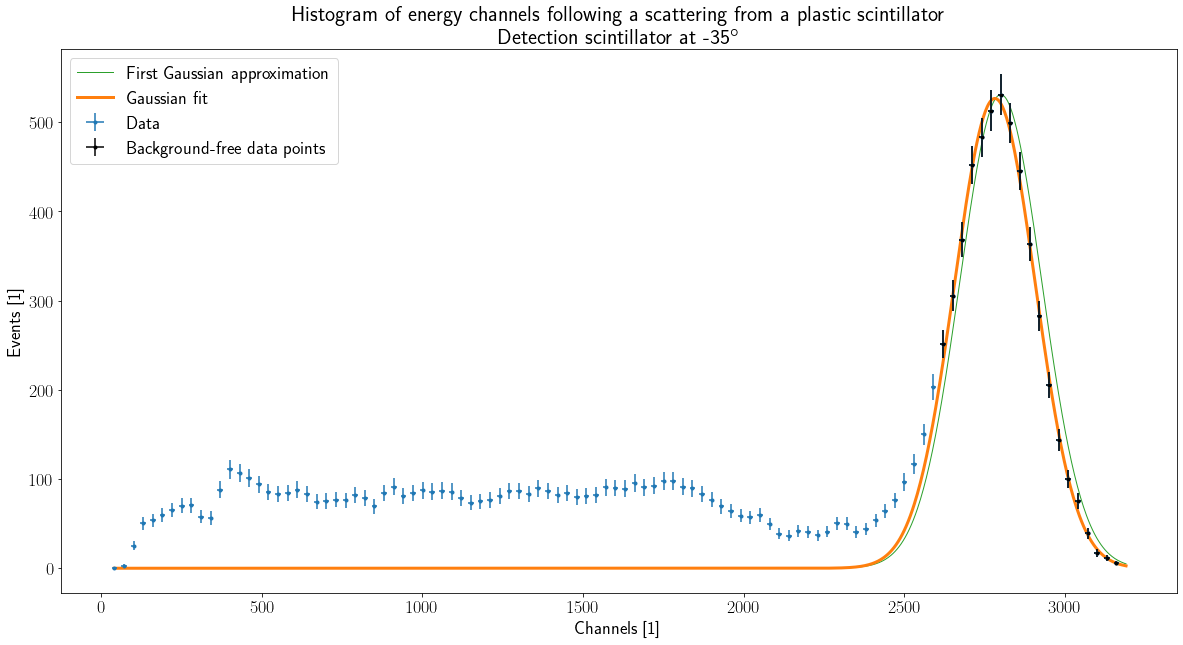

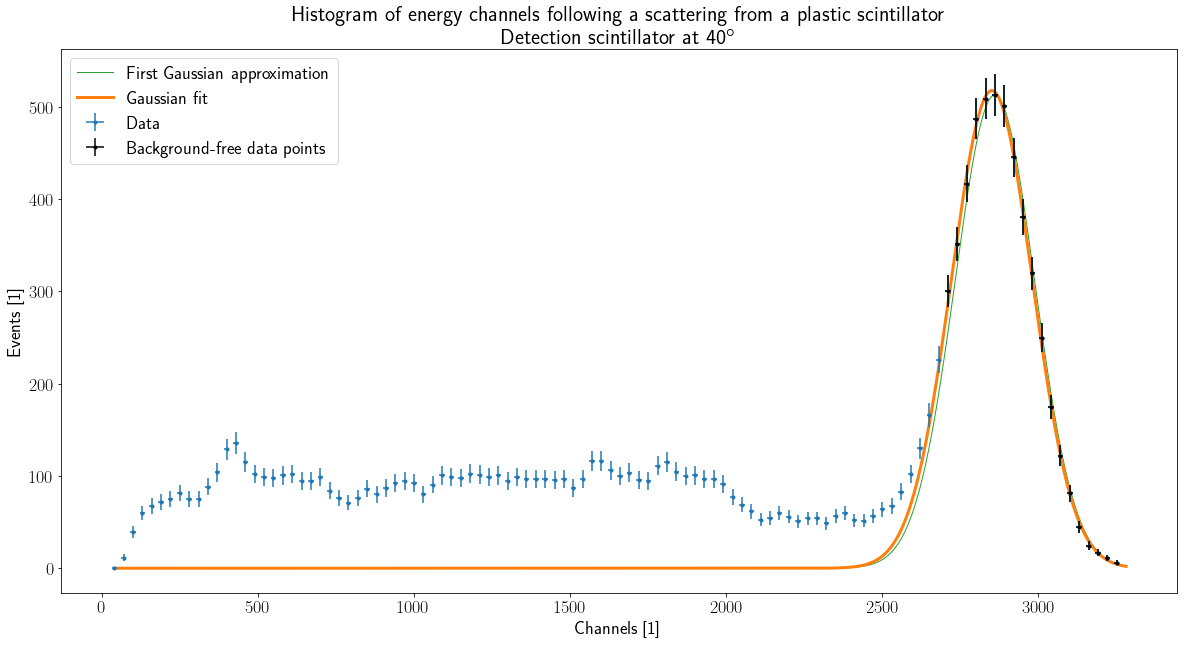

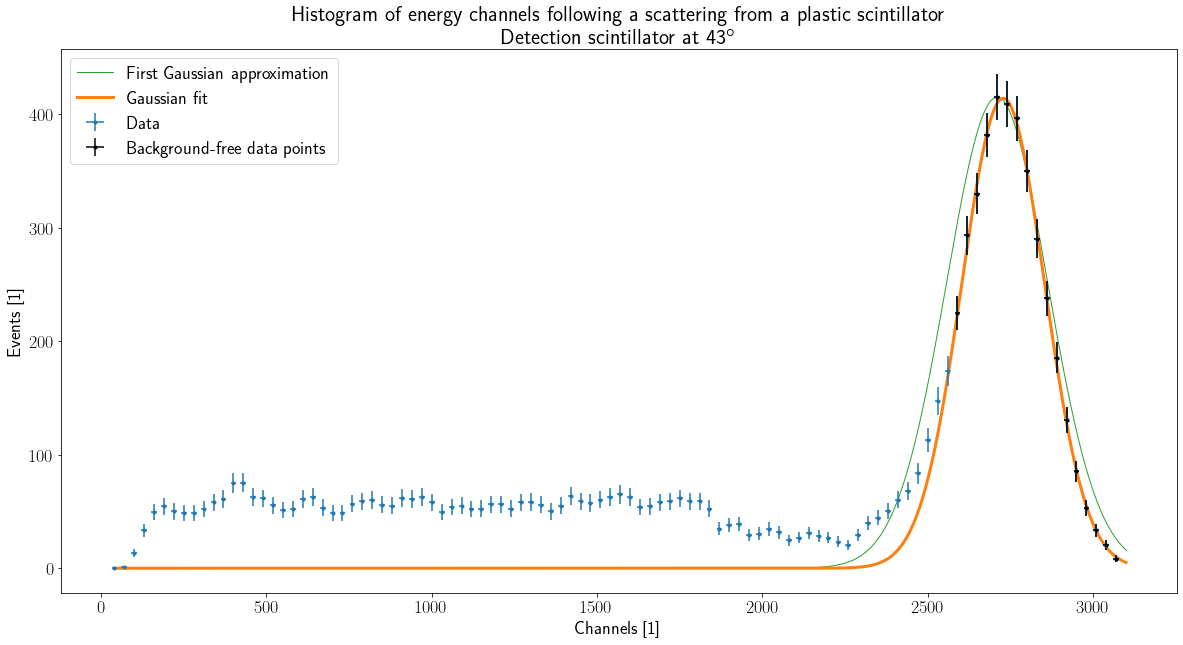

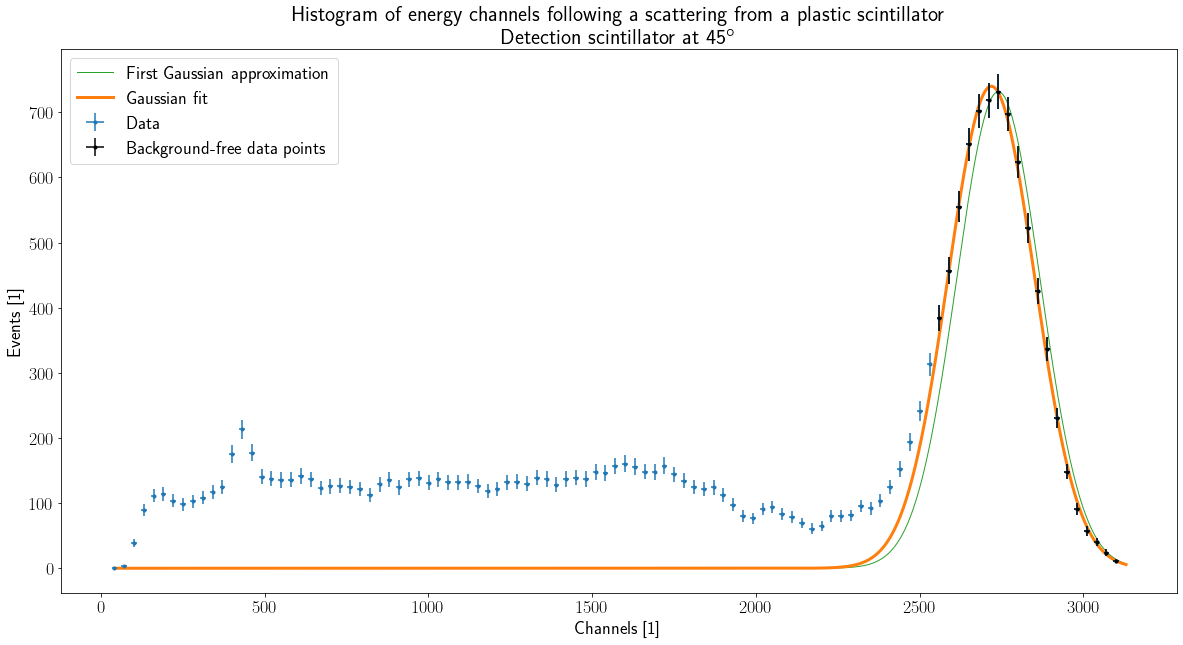

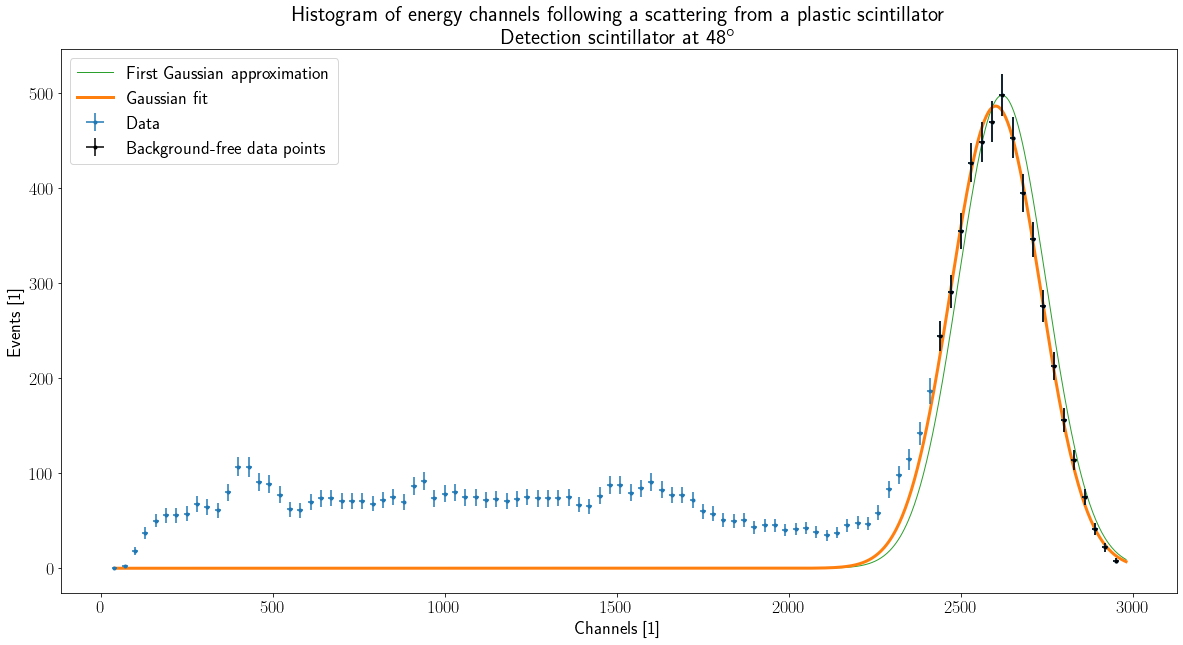

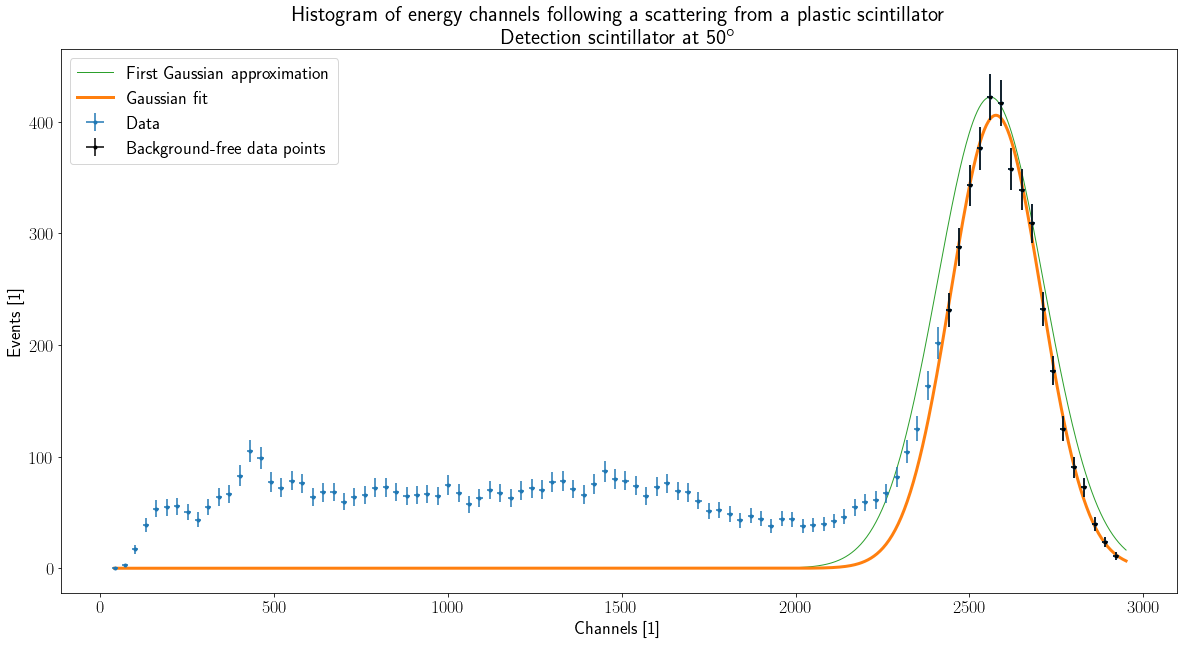

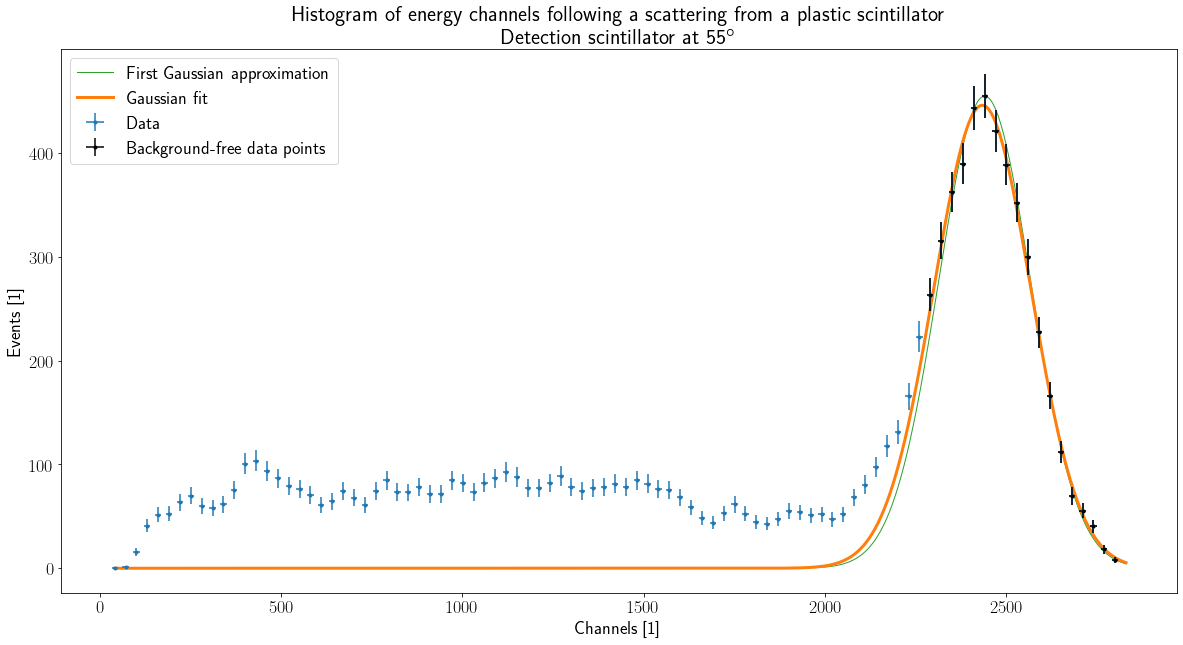

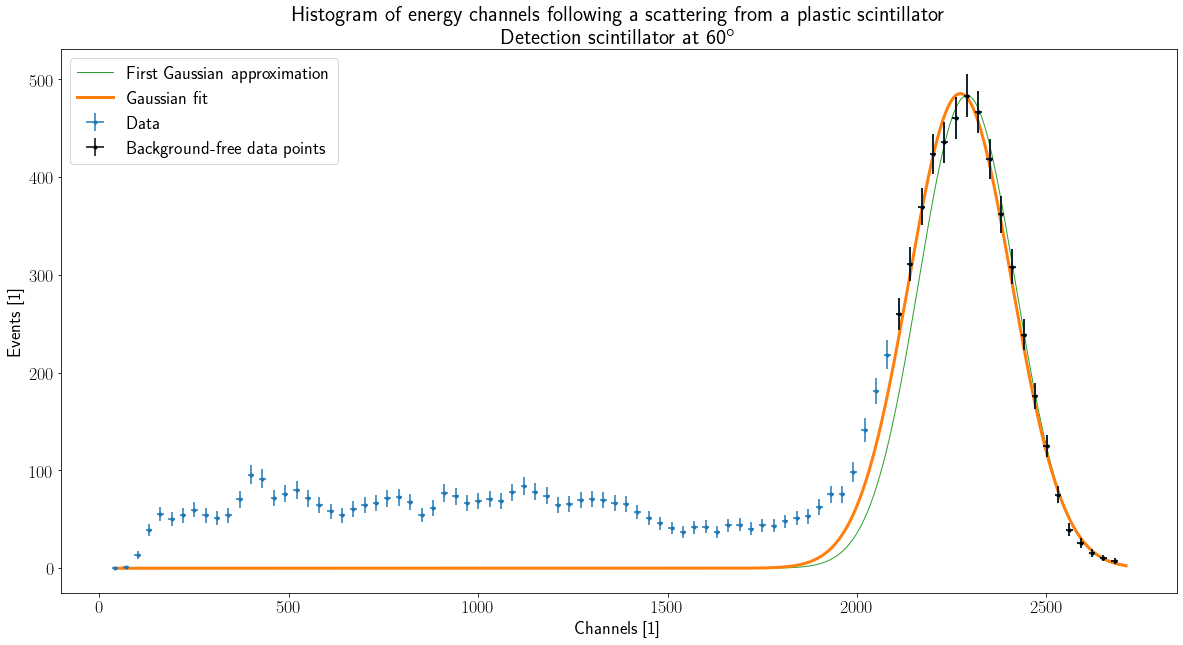

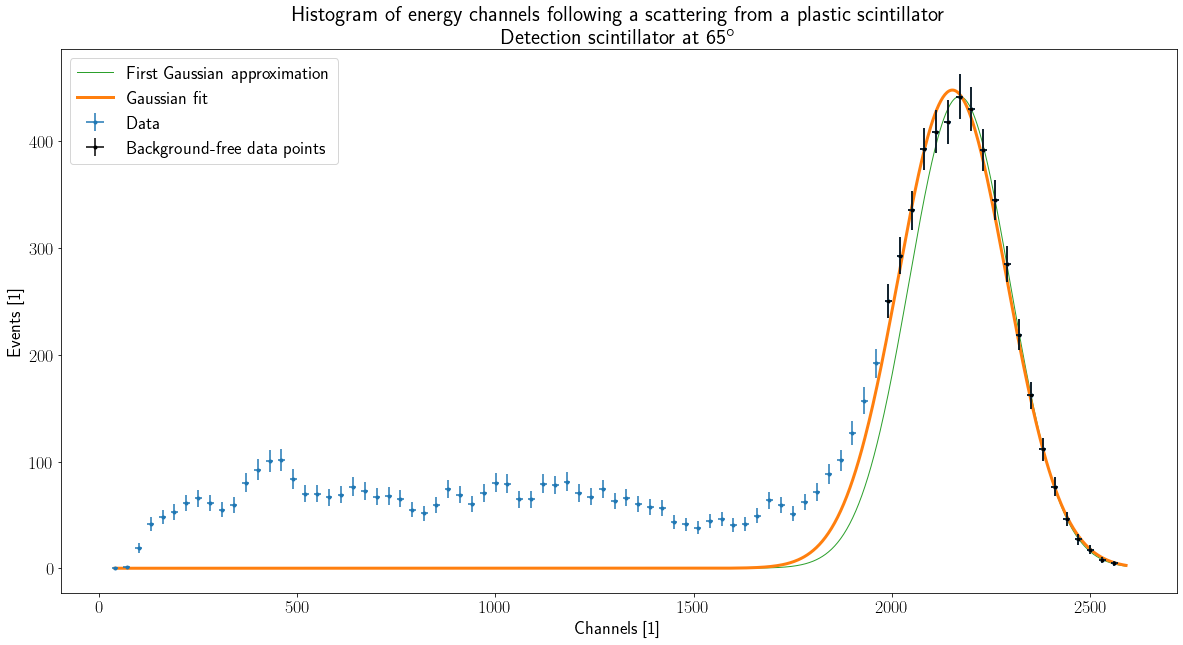

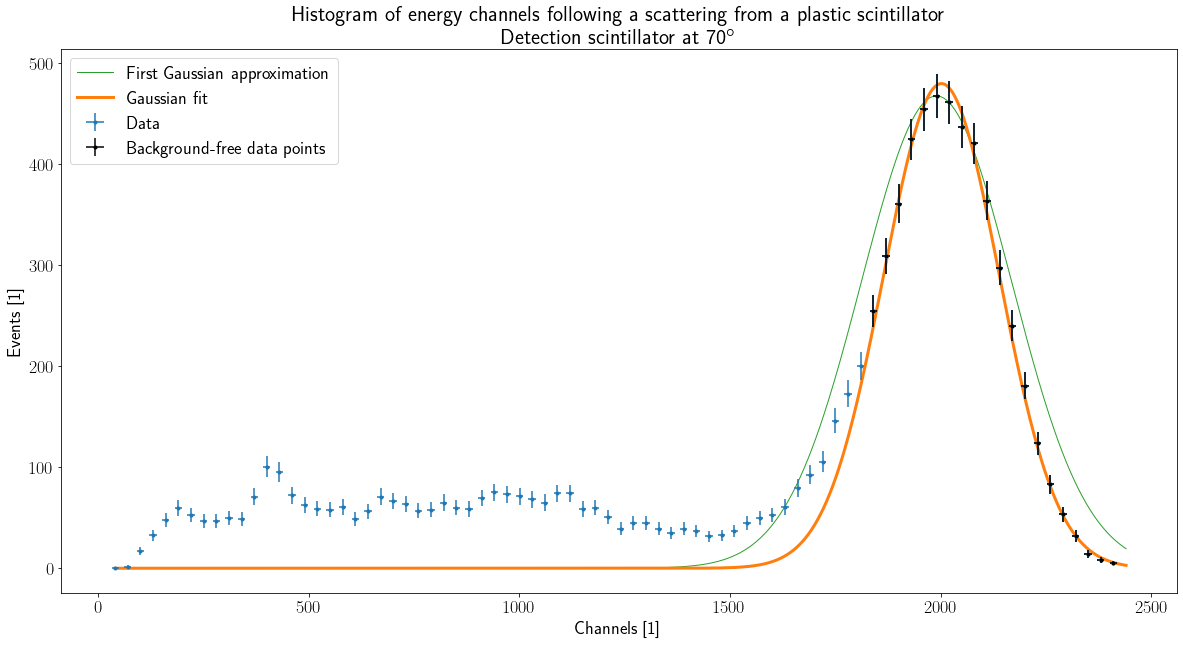

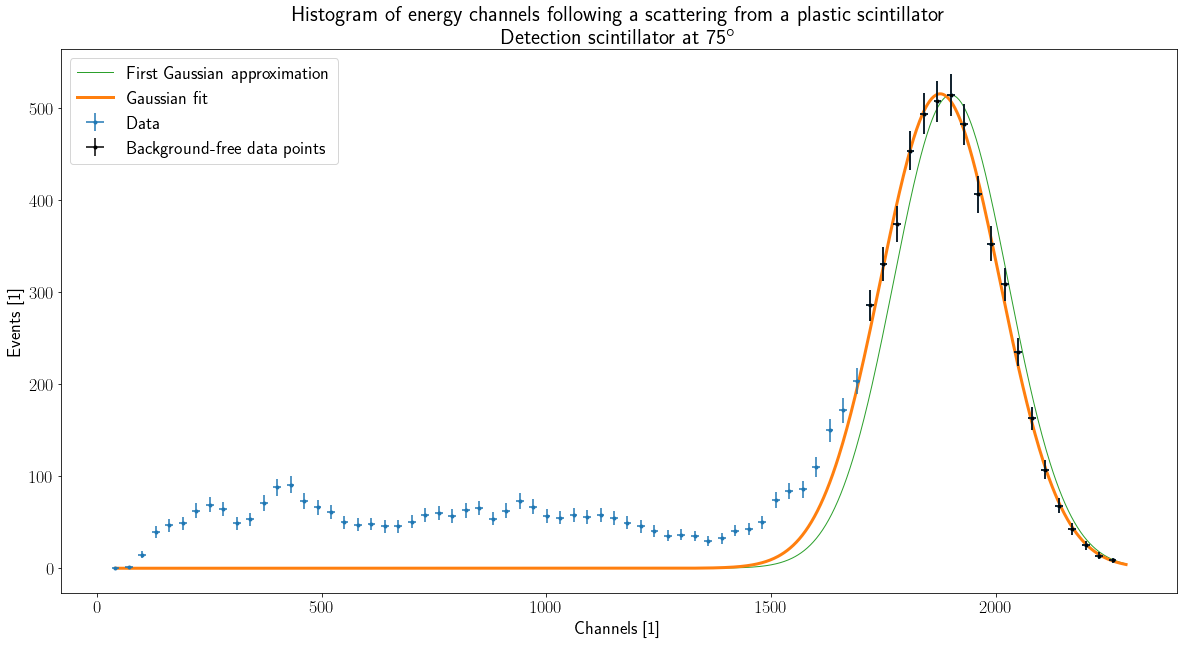

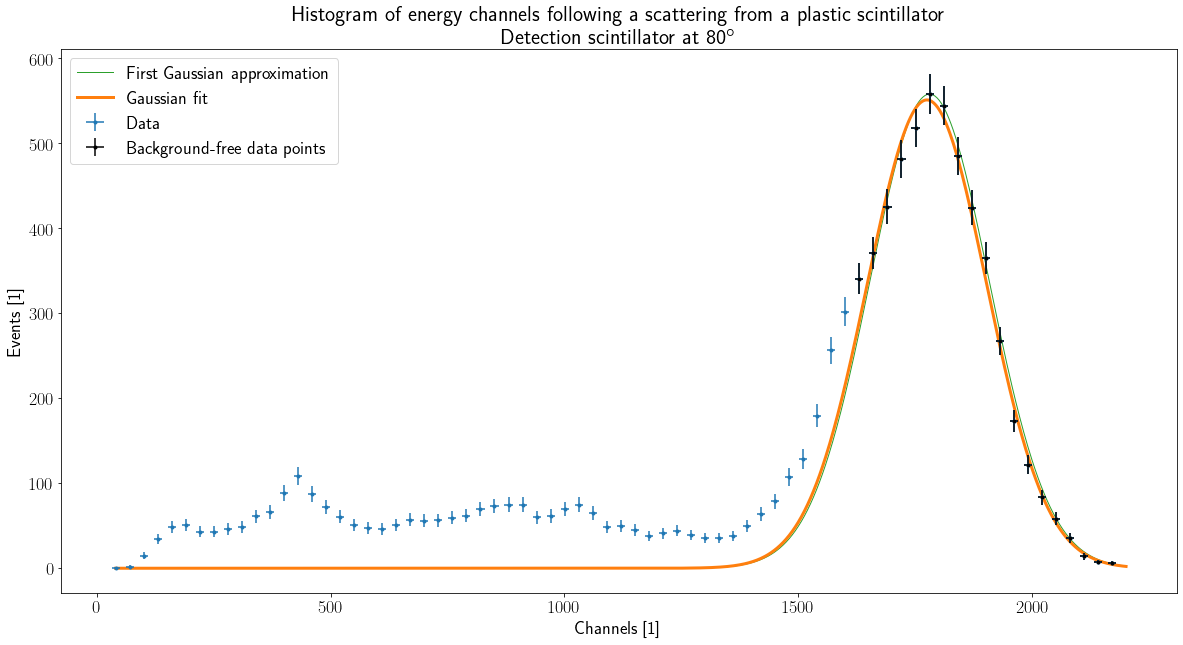

In [4]:
frac = 1/2
mu2 = []
hist = 30
cutoff = 1/100
width = 1
mvg = 2

for i in range(len(ndAngData)):
    rng = [0,3800]
    x, y = Histogram(chnnls[rng[0]:rng[1]],ndAngData[i][rng[0]:rng[1]], hist)
    x = moving_average(x, mvg)
    y = moving_average(y, mvg)
    peakIdx = int(np.argmax(y))
    leftIdx = len(y) - bisect(y[peakIdx:][::-1],y[peakIdx]*cutoff)
    sApprox = FWHM(x[:leftIdx],y[:leftIdx],peakIdx,frac,direction=1)
    lsigma = xover(x,x[peakIdx]+width*sApprox[0])-1
    rsigma = xover(y,y[lsigma])-1
    bkgIdx = xover(x,x[peakIdx]-3*sApprox[0])-1
    bkgAvg = np.sum(y[:bkgIdx])/(bkgIdx+1)
    gssData = eddington.FittingData(dict(x=x[rsigma:leftIdx], dx=np.full_like(x[rsigma:leftIdx], hist/np.sqrt(12)),
                                         y=y[rsigma:leftIdx], dy = np.sqrt(y[rsigma:leftIdx])))
    gssRe = eddington.fit(gssData, Gaussian, a0=[0.9*y[peakIdx]*np.sqrt(2*np.pi)*sApprox[0], sApprox[0], x[peakIdx]])
    mu2.append([gssRe.a[2],gssRe.a[1]/np.sqrt(gssRe.a[0]),ndAng[i],1/np.sqrt(12),gssRe.a[0]/hist,np.sqrt(gssRe.a[0]+(bkgAvg)**2)/hist,livend[i]])
    
    smtX = np.linspace(x[0], x[leftIdx], num=1000)
    aNought = [y[peakIdx]*np.sqrt(2*np.pi)*sApprox[0], sApprox[0], x[peakIdx]]
#     BKGs.append([interp1d(x[:rsigma],y[:rsigma]-Gaussian(gssRe.a,x[:rsigma])), x[rsigma-1], y[peakIdx]])
    plt.title(f'Histogram of energy channels following a scattering from a plastic scintillator\nDetection scintillator at {ndAng[i]}'\
                  +r'$^{\boldsymbol{\circ}}$')
    
    plt.errorbar(x[:leftIdx], y[:leftIdx], xerr=np.full_like(x[:leftIdx], hist/np.sqrt(12)), yerr=np.sqrt(y[:leftIdx]), zorder=1, fmt='.', label='Data')
    plt.errorbar(gssData.x, gssData.y, xerr=gssData.xerr, yerr=gssData.yerr, zorder=1, color='k', fmt='.', label='Background-free data points')
    plt.plot(smtX,Gaussian(aNought,smtX), linewidth=1, c='tab:green', zorder=-1, label='First Gaussian approximation')
    plt.plot(smtX,Gaussian(gssRe.a,smtX), linewidth=3, c='tab:orange', zorder=0,label='Gaussian fit')
#     plt.bar(x[:leftIdx], y[:leftIdx], yerr=np.sqrt(y[:leftIdx]), width=0.8*hist, snap=False, zorder=0)
#     plt.bar(gssData.x, gssData.y, yerr=gssData.yerr, width=0.8*hist, snap=False, zorder=1, color='tab:purple')
    plt.xlabel('Channels [1]')
    plt.ylabel('Events [1]')
    plt.legend()
    plt.savefig(f"Fits/TwoGauss/ScintillatorTwoGaussFit-{'P' if ndAng[i]>0 else 'N'}{np.abs(ndAng[i])}.pdf")
    plt.show()

mu2 = np.array(mu2).T
with open(brn+'SciMu.pickle', 'wb') as f:
    pickle.dump(mu2, f)

In [ ]:
# BKGs = []
# def BKGfunc(BKGlist, xList):
#     bkgSum = np.zeros_like(xList)
#     num = np.zeros_like(xList)
#     maxPik = np.max(BKGlist.T[2])
#     for BKGd in BKGlist:
#         num+=xList<BKGd[1]
#         bkg = BKGd[0](xList[xList<BKGd[1]])
#         bkgSum+=np.pad(bkg,(0,len(bkgSum)-len(bkg)))*BKGd[2]/maxPik
#     if sum(num)>0:
#         np.seterr(invalid='ignore')
#         M=bkgSum/num
#         M[np.isnan(M)] = 0
#         return M
#     else:
#         return bkgSum

In [ ]:
#     x = moving_average(xtag, 3)
#     y = moving_average(ytag, 3)
#     x = x[y>0]
#     y = y[y>0]
#     sApprox = FWHM(x, y-BKG, np.argmax(y-BKG), frac)
#     edge = [int((x[sApprox[1]]+x[sApprox[2]])/2 - 2*sApprox[0]), 
#             int((x[sApprox[1]]+x[sApprox[2]])/2 + 4*sApprox[0])]
#     xtag, ytag = Histogram(chnnls[edge[0]:edge[1]],ndAngData[i][edge[0]:edge[1]], 15)
#     xtag = xtag[ytag>0]
#     ytag = ytag[ytag>0]
#     gssData = eddington.FittingData(dict(x=xtag, dx = np.full_like(xtag,15/np.sqrt(12)), y=ytag/15, dy=np.sqrt(ytag/15)))
#     gssRe = eddington.fit(gssData, Gaussian, a0=[np.sum(ytag/15),sApprox[0],(x[sApprox[1]]+x[sApprox[2]])/2])
#     plt.bar(x, y, width=0.8*hist, snap=False)
#     plt.plot(x,y-np.pad(thirtyBKG*np.max(y)/thirtyMax, (0,len(y)-len(thirtyBKG))), c='r')
#     mu2.append([gssRe.a[2],gssRe.a[1]/np.sqrt(gssRe.a[0]),ndAng[i],1/np.sqrt(12), gssRe.a[0], gssRe.aerr[0],livend[i]])
#     plt.title(f'Sci - Angle = {ndAng[i]}')
#     plt.show()

Results:

Initial parameters' values:
	0.0016666666666666668 0.0019569471624266144 0.11117747335203879
Fitted parameters' values:
	a[0] = 1.41052e-3 ± 1.236e-5 (0.8765% error)
	a[1] = 1.94143e-3 ± 3.175e-5 (1.635% error)
	a[2] = 6.0906e-2 ± 3.451e-3 (5.666% error)
Fitted parameters covariance:
[[ 2.135e-11 -5.014e-11 -1.152e-10]
 [-5.014e-11  1.408e-10  2.233e-09]
 [-1.152e-10  2.233e-09  1.663e-06]]
Chi squared: 100.2
Degrees of freedom: 14
Chi squared reduced: 7.159
P-probability: 4.302e-15

3.489644573267833


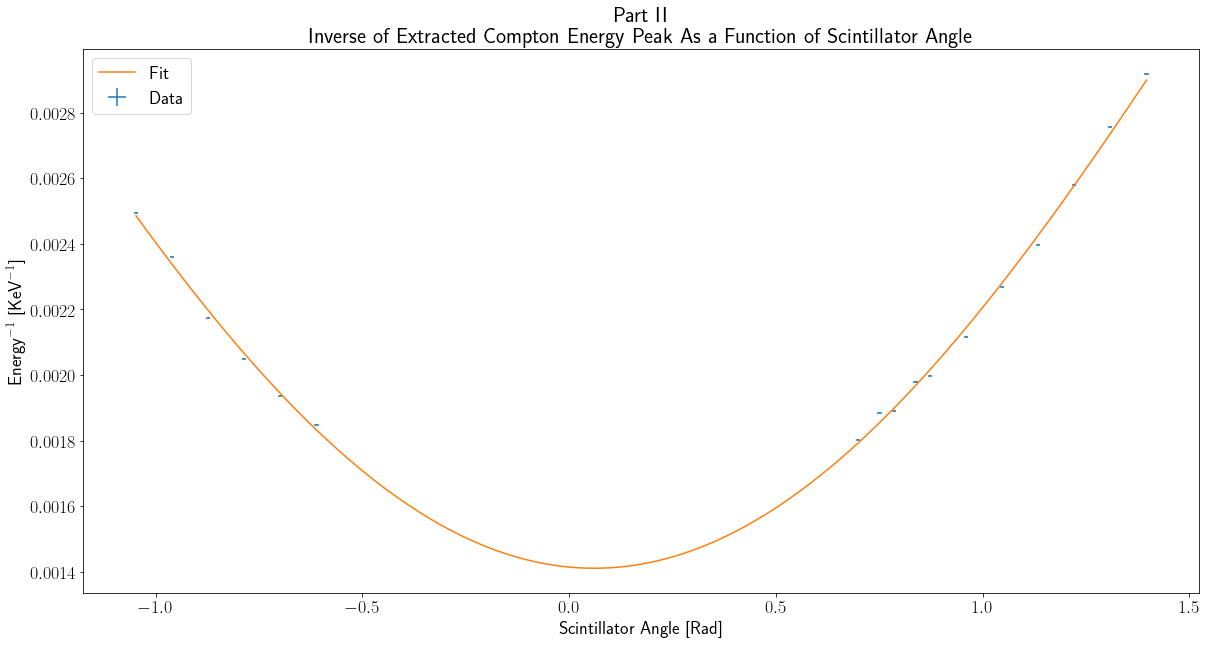

In [5]:
with open(brn+'SciMu.pickle', 'rb') as f:
    mu2 = pickle.load(f)
mu2[0] = 1/eddington.linear(engCali.a,mu2[0])
mu2[1] = mu2[1]*engCali.a[1]*mu2[0]**2
mu2[2] = mu2[2]*np.pi/180
mu2[3] = mu2[3]*np.pi/180
fitData = eddington.FittingData(dict(x=mu2[2],dx=mu2[3],y=mu2[0],dy=mu2[1]))
re = eddington.fit(fitData, comptonEnergyAnglewith3param, [1/600, 1/511, 6.37*np.pi/180])
x = np.linspace(min(mu2[2]),max(mu2[2]), num=500)
re.save_txt('Fits/ScintillatorComptonEnergyFit.txt')
print(re)
print(re.a[2]*180/np.pi)
plt.errorbar(x=mu2[2],xerr=mu2[3],y=mu2[0],yerr=mu2[1], fmt=',', label='Data')
plt.plot(x, comptonEnergyAnglewith3param(re.a, x), label='Fit')
plt.xlabel(r'Scintillator Angle [Rad]')
plt.ylabel(r'Energy$^{-1}$ [KeV$^{-1}$]')
plt.title('Part II\nInverse of Extracted Compton Energy Peak As a Function of Scintillator Angle')
plt.legend()
plt.savefig('Fits/ScintillatorComptonEnergyFit.pdf')
plt.savefig('Fits/ScintillatorComptonEnergyFit.png')
plt.show()

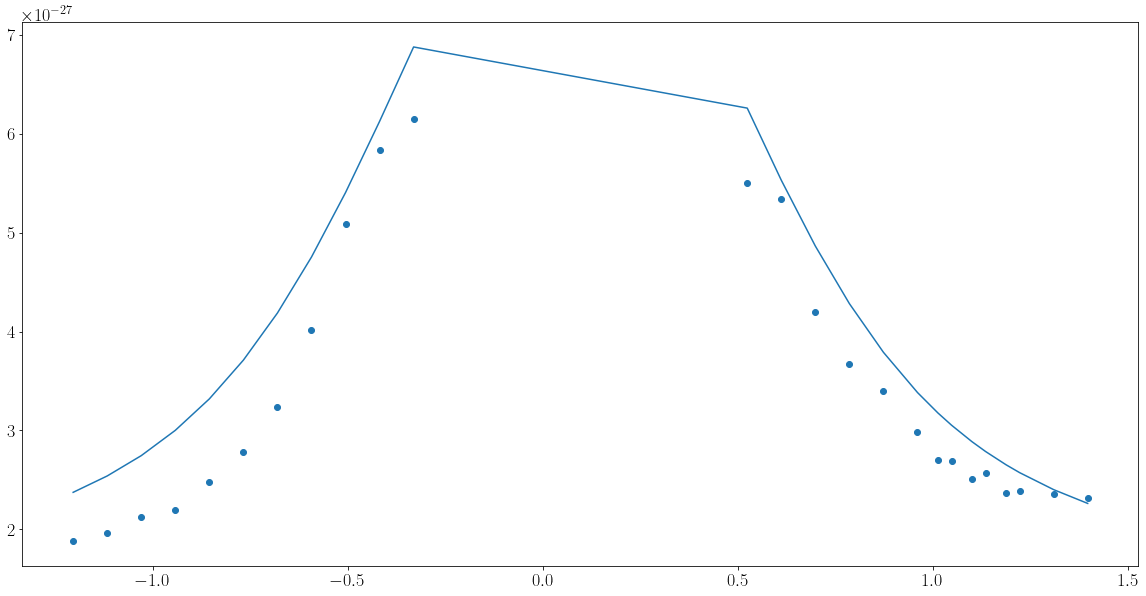

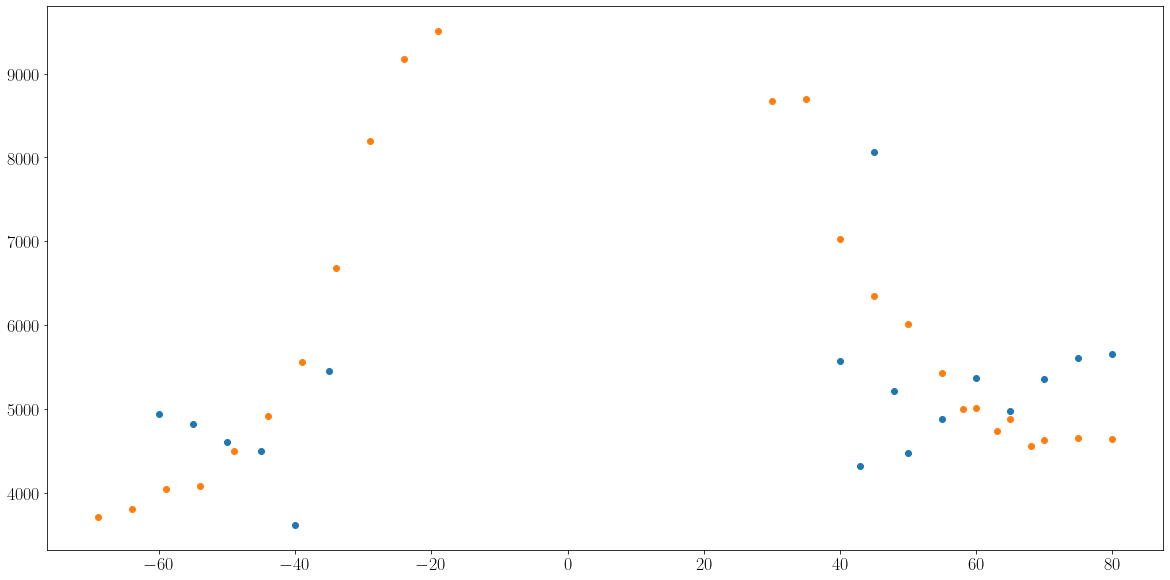

In [18]:
with open(brn+'SciMu.pickle', 'rb') as f:
    mu2 = pickle.load(f)
    
with open(brn+'AlRodMu.pickle', 'rb') as f:
    mu1 = pickle.load(f)

r0 = 2.82*10**(-13) # cm
sDet = np.pi*(7.62/2)**2 # cm^2
RAl = 15 #cm
Rsal = 81 #cm
AeffAl = 1.2*7 # cm^2
AeffSci = 32*70/100#cm^2
l = [np.pi*1.2/2, np.pi/2*32/10]
ne = [2.710/26.982 * 13 * 6.02214076*10**(23), 3.39*10**22]
NiN = [85.1/100*3.7*10**9*2**(-41/30.07)*mu1[6]*AeffAl/(4*np.pi*Rsal**2), 
       85.1/100*3.7*10**9*2**(-41/30.07)*mu2[6]*AeffSci/(4*np.pi*Rsal**2)]
Nsc = [mu1[4]/eddington.linear(reLin.a, eddington.linear(engCali.a,mu1[0])),
       mu2[4]/eddington.linear(reLin.a, eddington.linear(engCali.a,mu2[0]))]
dsdO=[Nsc[0]*(RAl**2/sDet)/(NiN[0]*ne[0]*l[0]),
      Nsc[1]*(RAl**2/sDet)/(NiN[1]*ne[1]*l[1])]
plt.scatter(mu1[2]*np.pi/180, dsdO[0])
# plt.scatter(mu2[2]*np.pi/180, dsdO[1])
plt.plot(mu1[2]*np.pi/180, NishinaCrossSection([r0/2.1, 3.45*np.pi/180, 661/511],mu1[2]*np.pi/180))
plt.show()
plt.scatter(mu2[2], mu2[4])
plt.scatter(mu1[2],mu1[4]) # Maybe a const error
plt.show()